# Análisis Exploratorio de Datos - Pruebas Saber 11

## Pontificia Universidad Javeriana - Facultad de Ciencias

**Proyecto:** Modelos de Comportamiento para la Predicción de Resultados por Municipios en Colombia de las Pruebas Saber 11 - ICFES

**Autor:** Santiago Andrés Ramírez Montero  
**Director:** John Jairo Corredor Franco  
**Año:** 2025

---

## Objetivo del Análisis

Realicé un análisis exploratorio exhaustivo de los datos históricos de las pruebas Saber 11 para los municipios de Bucaramanga y Santa Marta, abarcando los periodos 2014-2024. Este análisis me permitió:

- Comprender la estructura y calidad de los datos disponibles
- Identificar patrones de desempeño académico entre municipios
- Detectar valores atípicos y datos faltantes que requieren tratamiento
- Establecer la base para la construcción de modelos predictivos

El procesamiento se realizó utilizando Apache Spark para manejar eficientemente el gran volumen de información contenido en múltiples archivos de texto.

## 1. Configuración del Entorno de Trabajo

Configuré el entorno de análisis con las herramientas necesarias para procesamiento distribuido de datos y visualización. Utilizo Apache Spark como motor principal de procesamiento debido al volumen considerable de datos históricos.

In [ ]:
# Importación de librerías para procesamiento y visualización
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import os, glob, re
import warnings
warnings.filterwarnings('ignore')

# Configuración de estilo para visualizaciones
plt.style.use('seaborn-v0_8-whitegrid')
%matplotlib inline

# Inicialización de sesión Spark con configuración optimizada
# Ajusté los parámetros de memoria y particiones según el volumen de datos
spark = (SparkSession.builder
         .appName('Analisis_Saber11')
         .config('spark.sql.shuffle.partitions', '200')
         .config('spark.driver.memory', '4g')
         .getOrCreate())

print(f"Apache Spark versión: {spark.version}")
print("Entorno configurado correctamente")

Spark version: 4.0.0


In [ ]:
# Configuración de Hadoop para entorno Windows
# Esta celda asegura la correcta configuración de dependencias de Hadoop en Windows
import os, pathlib, importlib.util, sys

print('Verificando configuración de Hadoop para Windows...')

if os.name != 'nt':
    print('Sistema operativo: No Windows - No requiere configuración especial')
else:
    # Verifico si HADOOP_HOME ya está configurado
    if 'HADOOP_HOME' in os.environ and pathlib.Path(os.environ['HADOOP_HOME'],'bin','winutils.exe').exists():
        print(f'HADOOP_HOME ya configurado correctamente: {os.environ["HADOOP_HOME"]}')
    else:
        # Intento usar el paquete hadoop-winutils si está instalado
        spec = importlib.util.find_spec('hadoop')
        if spec is None:
            print('Advertencia: Paquete hadoop-winutils no instalado')
            print('Para habilitar escritura de archivos Parquet/CSV con Spark:')
            print('   Ejecutar: pip install hadoop-winutils')
            print('   Luego re-ejecutar esta celda')
        else:
            import hadoop
            hadoop_home = pathlib.Path(hadoop.__file__).parent
            winutils = hadoop_home / 'bin' / 'winutils.exe'
            
            if winutils.exists():
                os.environ['HADOOP_HOME'] = str(hadoop_home)
                os.environ['PATH'] = str(hadoop_home / 'bin') + os.pathsep + os.environ.get('PATH','')
                print(f'HADOOP_HOME configurado automáticamente: {os.environ["HADOOP_HOME"]}')
                print('winutils.exe detectado - Spark puede escribir archivos correctamente')
            else:
                print('El paquete hadoop-winutils está instalado pero falta winutils.exe')
                print('Reinstalar con: pip install --force-reinstall hadoop-winutils')
    
    # Verificación final
    if 'HADOOP_HOME' not in os.environ:
        print('\nEstado: HADOOP_HOME no configurado')
        print('Limitación: Spark no podrá escribir archivos CSV/Parquet hasta resolver esto')
    else:
        test_path = pathlib.Path(os.environ['HADOOP_HOME'],'bin','winutils.exe')
        if test_path.exists():
            print('\nVerificación exitosa: Entorno Hadoop listo para operación')
        else:
            print('\nAdvertencia: HADOOP_HOME definido pero winutils.exe no encontrado')

Verificando entorno Hadoop en Windows...
Paquete hadoop-winutils NO instalado.
Instalar ejecutando (una sola vez): !pip install hadoop-winutils
Luego re-ejecutar esta celda.

AUN SIN HADOOP_HOME: hasta configurarlo, Spark no podra escribir CSV/Parquet en Windows.


### 1.1 Inicialización de Sesión Spark

Inicializo la sesión de Apache Spark, configurando las opciones necesarias para el procesamiento distribuido de los datos del examen Saber 11. Esta sesión será el núcleo del análisis exploratorio que desarrollaré a continuación.

In [ ]:
# ============================================================================
# INICIALIZACIÓN DE SPARKSESSION - ANÁLISIS SABER 11
# ============================================================================
# CONFIGURACIÓN PARA DESARROLLO LOCAL:
# Esta configuración utiliza el modo local de Spark, apropiado para desarrollo
# y pruebas en una máquina individual.

# NOTA: Para ejecutar en un cluster Apache Spark de producción, reemplazar la
# inicialización actual con una de las siguientes opciones:
#
# OPCIÓN 1 - CLUSTER STANDALONE:
# spark = SparkSession.builder \
#     .appName("Analisis Saber 11") \
#     .master("spark://master-node:7077") \
#     .config("spark.executor.memory", "8g") \
#     .config("spark.executor.cores", "4") \
#     .config("spark.executor.instances", "10") \
#     .config("spark.driver.memory", "4g") \
#     .config("spark.sql.shuffle.partitions", "400") \
#     .getOrCreate()
#
# OPCIÓN 2 - CLUSTER YARN:
# spark = SparkSession.builder \
#     .appName("Analisis Saber 11") \
#     .master("yarn") \
#     .config("spark.submit.deployMode", "client") \
#     .config("spark.executor.memory", "8g") \
#     .config("spark.executor.cores", "4") \
#     .config("spark.dynamicAllocation.enabled", "true") \
#     .config("spark.driver.memory", "4g") \
#     .getOrCreate()
#
# IMPORTANTE: Al usar cluster, modificar las rutas de archivos de local a HDFS:
# - Cambiar: 'datos/archivo.csv'
# - Por: 'hdfs://namenode:9000/user/nombre_usuario/datos/archivo.csv'
# ============================================================================

# Inicializo SparkSession con configuraciones optimizadas para mi análisis
# Las opciones de configuración permiten manejo eficiente de memoria y paralelismo
spark = SparkSession.builder \
    .appName("Analisis Saber 11") \
    .config("spark.sql.shuffle.partitions", "4") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.memory.storageFraction", "0.3") \
    .getOrCreate()

# Configuro el nivel de log para reducir salida verbosa durante la ejecución
spark.sparkContext.setLogLevel("ERROR")

print("Sesión Spark inicializada correctamente")
print(f"Versión de Spark: {spark.version}")
print(f"Master: {spark.sparkContext.master}")
print(f"Nombre de aplicación: {spark.sparkContext.appName}")
print(f"Particiones para shuffle: {spark.conf.get('spark.sql.shuffle.partitions')}")
print(f"Memoria del driver: {spark.conf.get('spark.driver.memory')}")
print(f"Memoria del executor: {spark.conf.get('spark.executor.memory')}")

# Defino el esquema de datos para asegurar tipos correctos al cargar los archivos
# Este esquema refleja la estructura de los datos del ICFES Saber 11
schema = StructType([
    StructField("ESTU_CONSECUTIVO", StringType(), True),
    StructField("COLE_COD_DANE_ESTABLECIMIENTO", StringType(), True),
    StructField("ESTU_PAIS_RESIDE", StringType(), True),
    StructField("ESTU_DEPTO_RESIDE", StringType(), True),
    StructField("ESTU_COD_RESIDE_DEPTO", StringType(), True),
    StructField("ESTU_MCPIO_RESIDE", StringType(), True),
    StructField("ESTU_COD_RESIDE_MCPIO", StringType(), True),
    StructField("COLE_NOMBRE_ESTABLECIMIENTO", StringType(), True),
    StructField("ESTU_PRIVADO_LIBERTAD", StringType(), True)
])

print("\nEsquema de datos definido con 9 campos principales")

Dataset cargado -> Registros: 218,223 | Columnas: 181

Distribución por municipio (post-normalización):
+-----------+------+
|municipio  |count |
+-----------+------+
|BUCARAMANGA|125119|
|SANTA MARTA|93104 |
+-----------+------+

root
 |-- periodo: integer (nullable = true)
 |-- estu_consecutivo: string (nullable = true)
 |-- estu_estudiante: string (nullable = true)
 |-- cole_area_ubicacion: string (nullable = true)
 |-- cole_bilingue: string (nullable = true)
 |-- cole_calendario: string (nullable = true)
 |-- cole_caracter: string (nullable = true)
 |-- cole_cod_dane_establecimiento: long (nullable = true)
 |-- cole_cod_dane_sede: long (nullable = true)
 |-- cole_cod_depto_ubicacion: integer (nullable = true)
 |-- cole_cod_mcpio_ubicacion: integer (nullable = true)
 |-- cole_codigo_icfes: integer (nullable = true)
 |-- cole_depto_ubicacion: string (nullable = true)
 |-- cole_genero: string (nullable = true)
 |-- cole_jornada: string (nullable = true)
 |-- cole_mcpio_ubicacion: stri

In [ ]:
# Exploración inicial del dataset consolidado
# Verifico las dimensiones básicas y distribución de los datos cargados
print('EXPLORACION INICIAL DEL DATASET')
print('='*40)
print(f"Numero total de registros: {sdf_saber.count():,}")
print(f"Numero de columnas: {len(sdf_saber.columns)}")

print('\nDistribucion por periodo:')
sdf_saber.groupBy('periodo').count().orderBy('periodo').show(truncate=False)

print('\nDistribucion por municipio:')
sdf_saber.groupBy('municipio').count().orderBy('municipio').show(truncate=False)

EXPLORACION INICIAL (Spark)
Numero total de registros: 218,223
Numero de columnas: 181

Distribucion por periodo:
+-------+-----+
|periodo|count|
+-------+-----+
|20142  |15801|
|20151  |6034 |
|20152  |15756|
|20161  |4135 |
|20162  |16121|
|20171  |4715 |
|20172  |15885|
|20181  |3684 |
|20182  |17121|
|20191  |4018 |
|20192  |17399|
|20201  |2624 |
|20202  |14964|
|20211  |2686 |
|20212  |16529|
|20221  |3833 |
|20222  |15849|
|20231  |4697 |
|20232  |16130|
|20241  |4836 |
+-------+-----+
only showing top 20 rows

Distribucion por municipio:
+-----------+------+
|municipio  |count |
+-----------+------+
|BUCARAMANGA|125119|
|SANTA MARTA|93104 |
+-----------+------+



In [ ]:
# Exportación del dataset unificado (Parquet y CSV)
# Esta celda guarda el dataset procesado en diferentes formatos para análisis posteriores
# El guardado está controlado por la bandera SAVE_OUTPUTS para evitar sobrescrituras accidentales

SAVE_OUTPUTS = globals().get('SAVE_OUTPUTS', False)
if not SAVE_OUTPUTS:
    print('Guardado desactivado (SAVE_OUTPUTS=False). No se exportarán archivos.')
else:
    output_parquet = 'saber_11_parquet'
    output_csv = 'saber_11_completo.csv'

    import sys, pathlib, os, glob as g, shutil

    # Verifico configuración de Hadoop para escritura en Windows
    if os.name == 'nt' and 'HADOOP_HOME' not in os.environ:
        print('Advertencia: HADOOP_HOME no definido. Intentando configuración automática...')
        candidate_dirs = [
            os.path.join(os.getcwd(), 'hadoop'),
            os.path.join(os.path.expanduser('~'), 'hadoop'),
            os.path.join(sys.prefix, 'hadoop')
        ]
        selected = None
        for d in candidate_dirs:
            if os.path.exists(os.path.join(d, 'bin', 'winutils.exe')):
                selected = d; break
        if selected:
            os.environ['HADOOP_HOME'] = selected
            os.environ['PATH'] = os.path.join(selected, 'bin') + os.pathsep + os.environ.get('PATH','')
            print(f'HADOOP_HOME configurado automáticamente en: {selected}')
        else:
            print('No se encontró winutils.exe. Si falla Parquet se usará solo CSV.')

    parquet_ok = True
    # Intento guardar en formato Parquet particionado por periodo
    try:
        sdf_saber.write.mode('overwrite').partitionBy('periodo').parquet(output_parquet)
        print(f'Dataset guardado en Parquet particionado: {output_parquet}')
    except Exception as e:
        parquet_ok = False
        print('\nError al escribir Parquet:')
        print(str(e)[:400] + ('...' if len(str(e))>400 else ''))
        print('Fallback: intentaré solo CSV consolidado.')

    # Exporto a CSV consolidado en un único archivo
    try:
        sdf_saber.repartition(1).write.mode('overwrite').option('header', True).csv('tmp_csv_full')
        csv_parts = g.glob('tmp_csv_full/part-*.csv')
        if csv_parts:
            if os.path.exists(output_csv):
                os.remove(output_csv)
            shutil.move(csv_parts[0], output_csv)
            shutil.rmtree('tmp_csv_full')
            size_mb = os.path.getsize(output_csv)/(1024*1024)
            print(f'CSV consolidado guardado: {output_csv} ({size_mb:.2f} MB)')
    except Exception as e:
        print('Error al escribir CSV:', e)

    # Resumen de exportación
    print(f'\nResumen del dataset exportado:')
    print(f'- Columnas: {len(sdf_saber.columns)}')
    periodos_list = sorted([r["periodo"] for r in sdf_saber.select("periodo").distinct().collect()])
    print(f'- Periodos: {", ".join(periodos_list)}')
    
    if 'cole_depto_ubicacion' in sdf_saber.columns:
        print(f'- Departamentos: {sdf_saber.select("cole_depto_ubicacion").distinct().count()}')
    if 'cole_mcpio_ubicacion' in sdf_saber.columns:
        print(f'- Municipios: {sdf_saber.select("cole_mcpio_ubicacion").distinct().count()}')

    if os.name == 'nt' and not parquet_ok:
        print('\nPara habilitar escritura Parquet en Windows:')
        print('  1. Ejecutar: pip install hadoop-winutils')
        print('  2. Definir HADOOP_HOME apuntando a la carpeta con bin/winutils.exe')

Guardado desactivado (SAVE_OUTPUTS=False). Se omite exportación Parquet/CSV.


In [ ]:
# Análisis descriptivo básico de columnas de puntaje
# Calculo estadísticas descriptivas para las variables numéricas principales del dataset
print('ANALISIS DESCRIPTIVO BASICO')
print('='*30)

# Identifico columnas de puntaje para análisis estadístico
punt_cols = [c for c in sdf_saber.columns if c.lower().startswith('punt_')]

# Convierto a tipo double para permitir cálculos numéricos
for c in punt_cols:
    sdf_saber = sdf_saber.withColumn(c, F.col(c).cast('double'))

# Filtro columnas que realmente contengan datos válidos (no solo nulos)
if punt_cols:
    counts_row = sdf_saber.agg(*[F.count(F.col(c)).alias(c) for c in punt_cols]).collect()[0].asDict()
    valid_cols = [c for c, cnt in counts_row.items() if cnt and cnt > 0]
else:
    valid_cols = []

print(f"Columnas de puntaje detectadas: {len(punt_cols)}")
print(f"Columnas con datos válidos: {len(valid_cols)}")

# Genero estadísticas descriptivas (count, mean, stddev, min, max, percentiles)
# El método summary de Spark ignora automáticamente valores nulos
if valid_cols:
    stats = sdf_saber.select(*[F.col(c) for c in valid_cols]).summary('count','mean','stddev','min','25%','50%','75%','max')
    stats.show(truncate=False)
else:
    print('No hay columnas de puntaje con datos no nulos para resumir.')

ANALISIS DESCRIPTIVO BASICO (Spark)
Columnas de puntaje detectadas: ['punt_biologia', 'punt_ciencias_sociales', 'punt_filosofia', 'punt_fisica', 'punt_ingles', 'punt_interdisc_medioambiente', 'punt_interdisc_violenciaysoc', 'punt_lenguaje', 'punt_matematicas', 'punt_profundiza_biologia', 'punt_profundiza_csociales', 'punt_profundiza_lenguaje', 'punt_profundiza_matematica', 'punt_quimica', 'punt_c_naturales', 'punt_global', 'punt_lectura_critica', 'punt_sociales_ciudadanas']
Columnas con datos válidos: ['punt_ingles', 'punt_matematicas', 'punt_c_naturales', 'punt_global', 'punt_lectura_critica', 'punt_sociales_ciudadanas']
Columnas de puntaje detectadas: ['punt_biologia', 'punt_ciencias_sociales', 'punt_filosofia', 'punt_fisica', 'punt_ingles', 'punt_interdisc_medioambiente', 'punt_interdisc_violenciaysoc', 'punt_lenguaje', 'punt_matematicas', 'punt_profundiza_biologia', 'punt_profundiza_csociales', 'punt_profundiza_lenguaje', 'punt_profundiza_matematica', 'punt_quimica', 'punt_c_natura

## 2. Análisis de Calidad de Datos

En esta sección evalúo la calidad del dataset identificando valores nulos, outliers y posibles inconsistencias que puedan afectar el análisis posterior. Este paso es fundamental para garantizar la confiabilidad de mis resultados.

ANALISIS DETALLADO DE VALORES NULOS (Spark)
Top columnas con nulos:
 - desemp_profundiza_biologia | nulos= 218223 | 100.00%
 - desemp_profundiza_csociales | nulos= 218223 | 100.00%
 - desemp_profundiza_lenguaje | nulos= 218223 | 100.00%
 - desemp_profundiza_matematica | nulos= 218223 | 100.00%
 - estu_anomatriculaprimero | nulos= 218223 | 100.00%
 - estu_anomatriculasexto | nulos= 218223 | 100.00%
 - estu_anoscolegioactual | nulos= 218223 | 100.00%
 - estu_anospreescolar  | nulos= 218223 | 100.00%
 - estu_anoterminobachiller | nulos= 218223 | 100.00%
 - estu_anoterminoquinto | nulos= 218223 | 100.00%
 - estu_antecedentes    | nulos= 218223 | 100.00%
 - estu_areareside      | nulos= 218223 | 100.00%
 - estu_cod_iesdeseada  | nulos= 218223 | 100.00%
 - estu_cod_mcpioiesdeseada | nulos= 218223 | 100.00%
 - estu_cod_programadeseado | nulos= 218223 | 100.00%
Top columnas con nulos:
 - desemp_profundiza_biologia | nulos= 218223 | 100.00%
 - desemp_profundiza_csociales | nulos= 218223 | 100.0

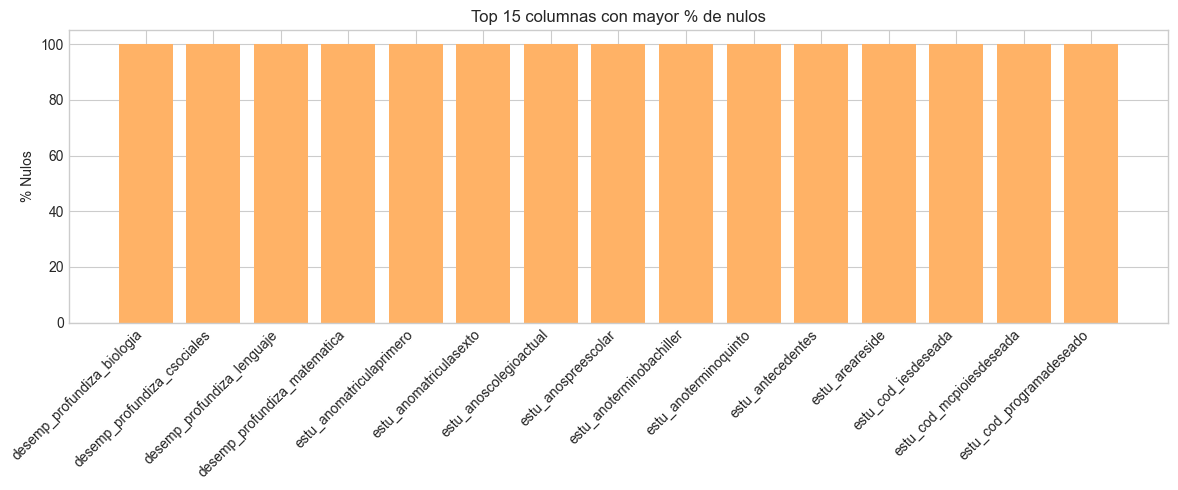

In [ ]:
# Análisis detallado de valores nulos en el dataset
# Identifico y cuantifico la presencia de valores faltantes en cada columna
print('ANALISIS DETALLADO DE VALORES NULOS')
print('='*45)

registros = sdf_saber.count()
null_counts = [F.count(F.when(F.col(c).isNull() | (F.isnan(F.col(c)) if c in ['punt_global','anio','p'] else F.lit(False)), c)).alias(c) for c in sdf_saber.columns]
row_nulls = sdf_saber.agg(*null_counts).collect()[0].asDict()

# Ordeno columnas por porcentaje de nulos (mayor a menor)
rows = sorted([(k, int(v), (int(v)/registros*100 if registros else 0.0)) for k,v in row_nulls.items()], key=lambda x: x[2], reverse=True)
print('Top 15 columnas con mayor proporción de nulos:')
for k, v, pct in rows[:15]:
    print(f" - {k:20} | nulos={v:7} | {pct:6.2f}%")

# Visualizo gráficamente el top 15 de columnas con nulos
import matplotlib.pyplot as plt
labels = [r[0] for r in rows[:15]]
vals = [r[2] for r in rows[:15]]
plt.figure(figsize=(12,5))
plt.bar(labels, vals, color='#FFB266')
plt.xticks(rotation=45, ha='right')
plt.ylabel('% Nulos')
plt.title('Top 15 columnas con mayor porcentaje de valores nulos')
plt.tight_layout(); plt.show()

# Interpretación: Esta gráfica me permite identificar rápidamente las variables con mayor cantidad
# de información faltante. Columnas con más del 50% de nulos probablemente no sean útiles para
# el modelado predictivo y deberían considerarse para eliminación.

In [ ]:
# Detección y análisis de outliers en columnas de puntaje
# Utilizo el método de rango intercuartílico (IQR) para identificar valores atípicos
print('ANALISIS DE OUTLIERS')
print('='*25)

outliers_info = []
for col in punt_cols[:25]:  # Limito análisis a primeras 25 columnas por desempeño
    q = sdf_saber.approxQuantile(col, [0.25,0.75], 0.01)
    if len(q)==2:
        Q1,Q3 = q
        IQR = Q3-Q1
        # Calculo límites de outliers según criterio de Tukey (1.5 * IQR)
        lim_inf = Q1-1.5*IQR
        lim_sup = Q3+1.5*IQR
        total_valid = sdf_saber.filter(F.col(col).isNotNull()).count()
        out_cnt = sdf_saber.filter((F.col(col)<lim_inf)|(F.col(col)>lim_sup)).count()
        pct = (out_cnt/total_valid*100) if total_valid else 0
        outliers_info.append((col,out_cnt,pct,lim_inf,lim_sup))
        print(f"{col}: Outliers={out_cnt} ({pct:.2f}%) Rango normal [{lim_inf:.2f}, {lim_sup:.2f}]")

# Presento un resumen ordenado por porcentaje de outliers
a = sorted(outliers_info, key=lambda x: x[2], reverse=True)[:10]
print('\nTop 10 columnas con mayor porcentaje de outliers:')
for col,out_cnt,pct,li,ls in a:
    print(f" - {col}: {pct:.2f}%")

# Interpretación: Los outliers pueden representar casos excepcionales o errores de captura.
# Un porcentaje alto sugiere distribución sesgada o presencia de valores extremos.

ANALISIS DE OUTLIERS (Spark)
punt_ingles: Outliers=3386 (1.56%) Rango normal [17.50, 85.50]
punt_ingles: Outliers=3386 (1.56%) Rango normal [17.50, 85.50]
punt_matematicas: Outliers=1650 (0.76%) Rango normal [17.00, 89.00]
punt_matematicas: Outliers=1650 (0.76%) Rango normal [17.00, 89.00]
punt_c_naturales: Outliers=834 (0.38%) Rango normal [17.50, 85.50]
punt_c_naturales: Outliers=834 (0.38%) Rango normal [17.50, 85.50]
punt_global: Outliers=542 (0.25%) Rango normal [99.50, 423.50]
punt_global: Outliers=542 (0.25%) Rango normal [99.50, 423.50]
punt_lectura_critica: Outliers=607 (0.28%) Rango normal [24.50, 84.50]
punt_lectura_critica: Outliers=607 (0.28%) Rango normal [24.50, 84.50]
punt_sociales_ciudadanas: Outliers=451 (0.21%) Rango normal [15.00, 87.00]

Top columnas con mayor % de outliers:
 - punt_ingles: 1.56%
 - punt_matematicas: 0.76%
 - punt_c_naturales: 0.38%
 - punt_lectura_critica: 0.28%
 - punt_global: 0.25%
 - punt_sociales_ciudadanas: 0.21%
punt_sociales_ciudadanas: Out

## 3. Visualizaciones y Análisis Descriptivo

En esta sección presento visualizaciones para comprender la distribución de los puntajes, el rendimiento comparativo entre municipios y la evolución temporal de las métricas académicas.

DISTRIBUCION DE PUNTAJES GLOBALES (CSV consolidado)
Estadisticas (Spark summary) de puntaje global:
Estadisticas (Spark summary) de puntaje global:
+-------+------------------+
|summary|punt_global       |
+-------+------------------+
|count  |218223            |
|mean   |264.13423424661926|
|stddev |55.80274954071063 |
|min    |0.0               |
|25%    |221.0             |
|50%    |260.0             |
|75%    |304.0             |
|max    |494.0             |
+-------+------------------+

+-------+------------------+
|summary|punt_global       |
+-------+------------------+
|count  |218223            |
|mean   |264.13423424661926|
|stddev |55.80274954071063 |
|min    |0.0               |
|25%    |221.0             |
|50%    |260.0             |
|75%    |304.0             |
|max    |494.0             |
+-------+------------------+



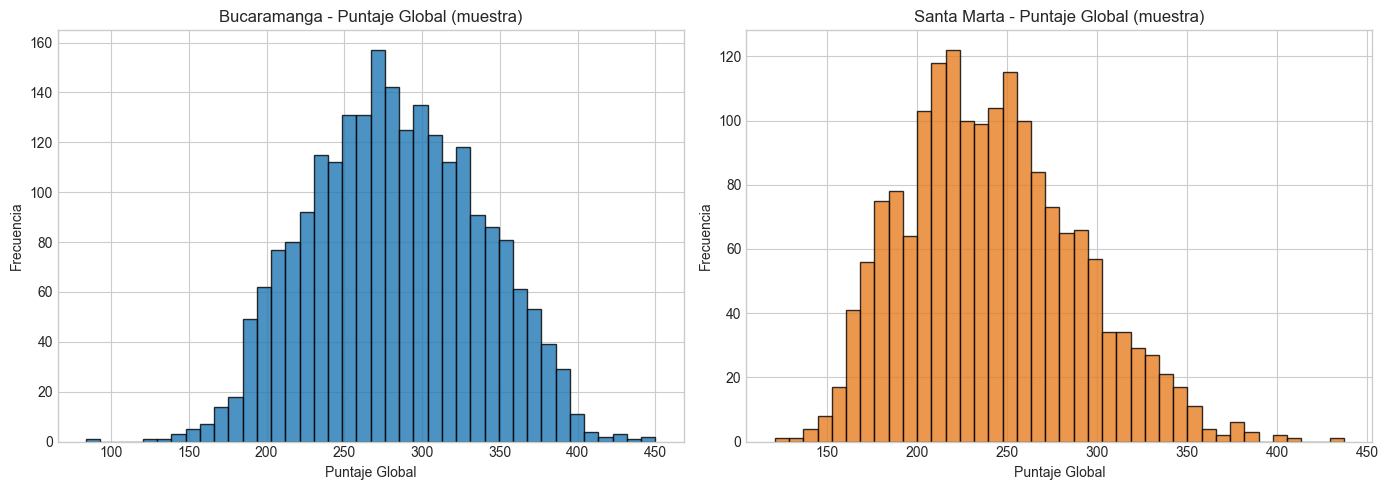

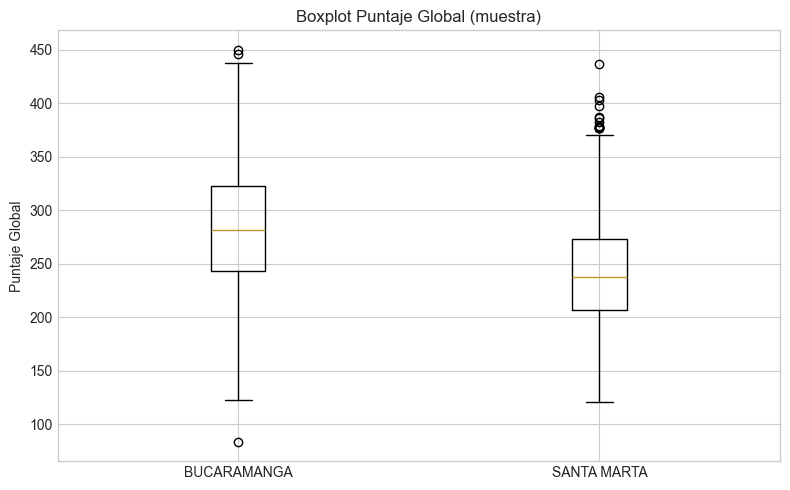

In [ ]:
# Distribución de puntajes globales comparando los dos municipios
# Analizo la distribución del puntaje global mediante histogramas y boxplots
print('DISTRIBUCION DE PUNTAJES GLOBALES POR MUNICIPIO')
print('='*55)

puntaje_col = 'punt_global'

# Tomo muestra aleatoria para visualización eficiente (4000 registros)
SAMPLE_SIZE = 4000
N = sdf_saber.count()
fraction = min(1.0, SAMPLE_SIZE / N) if N else 1.0
samp = (sdf_saber
        .select('municipio', F.col(puntaje_col).cast('double').alias(puntaje_col))
        .where(F.col(puntaje_col).isNotNull())
        .sample(withReplacement=False, fraction=fraction, seed=42))
vals = samp.collect()
vals_b = [r[puntaje_col] for r in vals if r['municipio']=='BUCARAMANGA']
vals_s = [r[puntaje_col] for r in vals if r['municipio']=='SANTA MARTA']

import numpy as np
import matplotlib.pyplot as plt

# Calculo estadísticas descriptivas completas con Spark
stats_global = (sdf_saber
                .select(F.col(puntaje_col).cast('double').alias(puntaje_col))
                .summary('count','mean','stddev','min','25%','50%','75%','max'))
print('Estadisticas descriptivas del puntaje global:')
stats_global.show(truncate=False)

# Genero histogramas comparativos por municipio
fig, axes = plt.subplots(1,2, figsize=(14,5))
axes[0].hist(vals_b, bins=40, alpha=0.8, color='#1F77B4', edgecolor='black')
axes[0].set_title('Bucaramanga - Distribución Puntaje Global')
axes[0].set_xlabel('Puntaje Global'); axes[0].set_ylabel('Frecuencia')

axes[1].hist(vals_s, bins=40, alpha=0.8, color='#E67E22', edgecolor='black')
axes[1].set_title('Santa Marta - Distribución Puntaje Global')
axes[1].set_xlabel('Puntaje Global'); axes[1].set_ylabel('Frecuencia')
plt.tight_layout(); plt.show()

# Genero boxplot comparativo entre municipios
plt.figure(figsize=(8,5))
plt.boxplot([vals_b, vals_s], labels=['BUCARAMANGA','SANTA MARTA'])
plt.title('Comparación Puntaje Global entre Municipios')
plt.ylabel('Puntaje Global')
plt.tight_layout(); plt.show()

# Interpretación: Los histogramas me permiten observar si las distribuciones son aproximadamente 
# normales o presentan sesgos. El boxplot facilita la comparación de medianas, dispersión y 
# presencia de valores atípicos entre ambos municipios.

In [ ]:
# Diagnóstico de columnas de puntajes y detección de puntaje global
# Verifico la existencia y rango de la columna de puntaje global en el dataset
print('DIAGNOSTICO DE COLUMNAS DE PUNTAJES')
print('='*40)

# Recolecto estadísticas básicas (min/max/count) para las primeras columnas de puntaje
max_check = 60
stats_list = []
for c in punt_cols[:max_check]:
    try:
        row = sdf_saber.select(
            F.count(F.col(c)).alias('count'),
            F.min(F.col(c).cast('double')).alias('min'),
            F.max(F.col(c).cast('double')).alias('max')
        ).first()
        stats_list.append((c, row['count'], row['min'], row['max']))
    except Exception as e:
        stats_list.append((c, None, None, None))

# Identifico posibles columnas de puntaje global (rango amplio, máximo >= 300)
posibles_global = [r for r in stats_list if r[3] is not None and r[3] >= 300]
print('Posibles columnas de puntaje global (max >= 300):')
for c, ct, mn, mx in sorted(posibles_global, key=lambda x: x[3], reverse=True):
    print(f" - {c}: min={mn} max={mx} count={ct}")

if not posibles_global:
    print('No se detectó una columna con max >= 300.')
    print('Nota: Si es necesario, se reconstruirá el puntaje global más adelante.')

# Verifico nombres típicos de columna de puntaje global
for nombre in ['PUNT_GLOBAL','punt_global','PUNT_GLOBAL_TOTAL']:
    if nombre in sdf_saber.columns:
        r = sdf_saber.select(F.min(nombre).alias('min'), F.max(nombre).alias('max')).first()
        print(f"Columna {nombre} encontrada - Rango: {r['min']} - {r['max']}")

DIAGNOSTICO DE COLUMNAS DE PUNTAJES
Posibles columnas de puntaje global (max >= 300):
 - punt_global: min=0.0 max=494.0 count=218223
Posibles columnas de puntaje global (max >= 300):
 - punt_global: min=0.0 max=494.0 count=218223
Columna punt_global rango: 0.0 - 494.0
Columna punt_global rango: 0.0 - 494.0


RANKING DE MUNICIPIOS
BUCARAMANGA: n=125,119 mean=282.11 median=282.00 sd=54.59 min=0.00 max=494.00
SANTA MARTA: n=93,104 mean=239.98 median=235.00 sd=47.71 min=0.00 max=493.00
BUCARAMANGA: n=125,119 mean=282.11 median=282.00 sd=54.59 min=0.00 max=494.00
SANTA MARTA: n=93,104 mean=239.98 median=235.00 sd=47.71 min=0.00 max=493.00


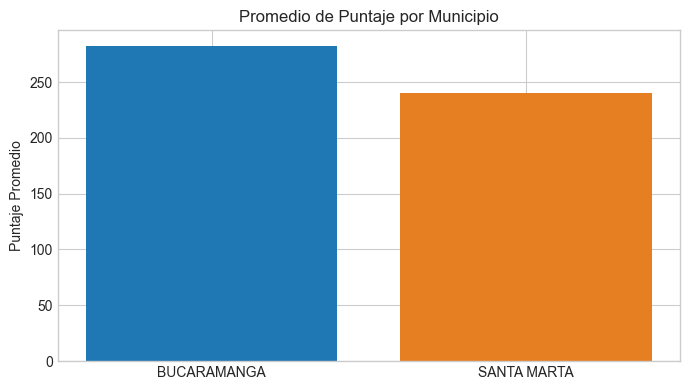

In [ ]:
# Ranking y comparación estadística entre municipios
# Calculo y comparo métricas de desempeño académico entre Bucaramanga y Santa Marta
print('RANKING DE MUNICIPIOS')
print('='*30)

puntaje_col_rk = 'punt_global'
muni_stats = (sdf_saber
              .select('municipio', F.col(puntaje_col_rk).cast('double').alias(puntaje_col_rk))
              .where(F.col(puntaje_col_rk).isNotNull())
              .groupBy('municipio')
              .agg(F.count('*').alias('n'),
                   F.mean(puntaje_col_rk).alias('mean'),
                   F.expr(f'percentile_approx({puntaje_col_rk},0.5)').alias('median'),
                   F.stddev(puntaje_col_rk).alias('std'),
                   F.min(puntaje_col_rk).alias('min'),
                   F.max(puntaje_col_rk).alias('max')))

rows = muni_stats.orderBy(F.col('mean').desc()).collect()
print('Estadísticas comparativas por municipio:')
for r in rows:
    print(f"{r['municipio']}: n={r['n']:,} mean={r['mean']:.2f} median={r['median']:.2f} sd={r['std']:.2f} min={r['min']:.2f} max={r['max']:.2f}")

# Genero gráfica de barras comparando promedios
import matplotlib.pyplot as plt
labels = [r['municipio'] for r in rows]
means = [r['mean'] for r in rows]
plt.figure(figsize=(7,4))
plt.bar(labels, means, color=['#1F77B4', '#E67E22'])
plt.title('Promedio de Puntaje Global por Municipio')
plt.ylabel('Puntaje Promedio')
plt.tight_layout(); plt.show()

# Interpretación: Esta comparación me permite identificar cuál municipio tiene mejor desempeño 
# académico promedio. La diferencia entre media y mediana indica simetría de la distribución.

ANALISIS POR DEPARTAMENTOS (Exploratorio)
Departamentos analizados: 32
Departamentos analizados: 32
+--------------------+-----+------------------+------+------------------+-----+-----+
|cole_depto_ubicacion|count|mean              |median|std               |min  |max  |
+--------------------+-----+------------------+------+------------------+-----+-----+
|CHOCO               |1    |361.0             |361.0 |NULL              |361.0|361.0|
|TOLIMA              |3    |292.0             |286.0 |16.822603841260722|279.0|311.0|
|RISARALDA           |22   |290.8636363636364 |287.0 |52.130144331777444|190.0|379.0|
|SUCRE               |2    |290.0             |246.0 |62.22539674441618 |246.0|334.0|
|SANTANDER           |85663|279.56348715314664|278.0 |53.75796371323869 |0.0  |478.0|
+--------------------+-----+------------------+------+------------------+-----+-----+
only showing top 5 rows
+--------------------+-----+------------------+------+------------------+-----+-----+
|cole_depto_ubic

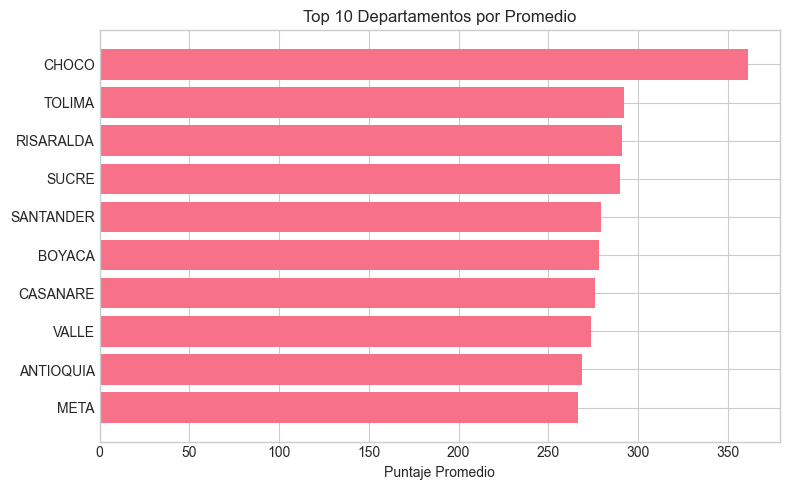

In [ ]:
# Análisis exploratorio por departamentos
# Examino el desempeño académico agregado a nivel departamental
print('ANALISIS POR DEPARTAMENTOS')
print('='*50)

dep_col = 'cole_depto_ubicacion'
puntaje_col_dep = None

# Busco la columna de puntaje global en el dataset
for c in sdf_saber.columns:
    if 'punt_global' in c.lower():
        puntaje_col_dep = c
        break

if puntaje_col_dep and dep_col in sdf_saber.columns:
    # Calculo estadísticas agregadas por departamento
    ranking_departamentos = (sdf_saber
                             .withColumn(puntaje_col_dep, F.col(puntaje_col_dep).cast('double'))
                             .groupBy(dep_col)
                             .agg(F.count('*').alias('count'),
                                  F.mean(puntaje_col_dep).alias('mean'),
                                  F.expr(f'percentile_approx({puntaje_col_dep},0.5)').alias('median'),
                                  F.stddev(puntaje_col_dep).alias('std'),
                                  F.min(puntaje_col_dep).alias('min'),
                                  F.max(puntaje_col_dep).alias('max'))
                             .orderBy(F.col('mean').desc()))
    
    print(f"Departamentos analizados: {ranking_departamentos.count()}")
    print('\nTop 5 departamentos por puntaje promedio:')
    ranking_departamentos.show(5, truncate=False)

    # Extraigo top 10 departamentos para visualización
    import numpy as np
    top_rows = (ranking_departamentos
                .where(F.col(dep_col).isNotNull() & F.col('mean').isNotNull())
                .orderBy(F.col('mean').desc())
                .limit(10)
                .collect())

    if top_rows:
        labels = [r[dep_col] if r[dep_col] is not None else 'DESCONOCIDO' for r in top_rows]
        means = [float(r['mean']) if r['mean'] is not None else np.nan for r in top_rows]
        # Filtro valores válidos para graficar
        pairs = [(lab, val) for lab, val in zip(labels, means) if isinstance(lab, str) and lab.strip() and np.isfinite(val)]
        
        if pairs:
            labs, vals = zip(*pairs)
            import matplotlib.pyplot as plt
            plt.figure(figsize=(8,5))
            # Invierto para barras horizontales ascendentes
            plt.barh(list(labs)[::-1], list(vals)[::-1])
            plt.title('Top 10 Departamentos por Puntaje Promedio')
            plt.xlabel('Puntaje Promedio')
            plt.tight_layout(); plt.show()
            
            # Interpretación: Esta gráfica me permite identificar las regiones con mejor desempeño 
            # académico agregado. Los departamentos con mayores promedios pueden servir como 
            # referencia de mejores prácticas educativas.
        else:
            print('No hay valores válidos para graficar después de filtrar nulos.')
    else:
        print('No hay filas disponibles para el top 10.')
else:
    print('No se pueden calcular estadísticas por departamento.')
    print('Falta la columna de puntaje global o la columna de departamento.')

TENDENCIAS TEMPORALES (Exploratorio)
Estadisticas por periodo (primeros 10):
{'periodo': 20142, 'count': 15801, 'mean': 258.2552370103158, 'median': 253.0, 'std': 48.60815659866266, 'min': 0.0, 'max': 454.0}
{'periodo': 20151, 'count': 6034, 'mean': 274.66622472654956, 'median': 270.0, 'std': 61.933161730175826, 'min': 74.0, 'max': 473.0}
{'periodo': 20152, 'count': 15756, 'mean': 257.48552932216296, 'median': 251.0, 'std': 53.494182186593655, 'min': 0.0, 'max': 478.0}
{'periodo': 20161, 'count': 4135, 'mean': 283.3211608222491, 'median': 281.0, 'std': 56.83848031327199, 'min': 77.0, 'max': 472.0}
{'periodo': 20162, 'count': 16121, 'mean': 265.6020718317722, 'median': 264.0, 'std': 52.68129178742786, 'min': 91.0, 'max': 458.0}
{'periodo': 20171, 'count': 4715, 'mean': 276.96712619300104, 'median': 279.0, 'std': 54.686715079882475, 'min': 84.0, 'max': 443.0}
{'periodo': 20172, 'count': 15885, 'mean': 264.4700031476236, 'median': 262.0, 'std': 53.60624026169849, 'min': 102.0, 'max': 446.

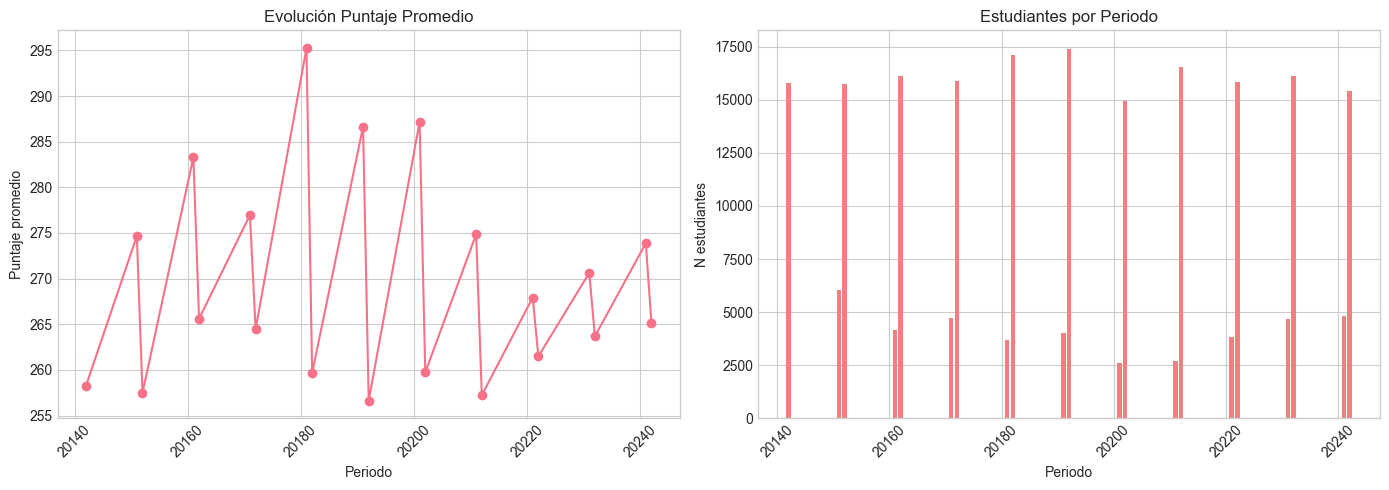

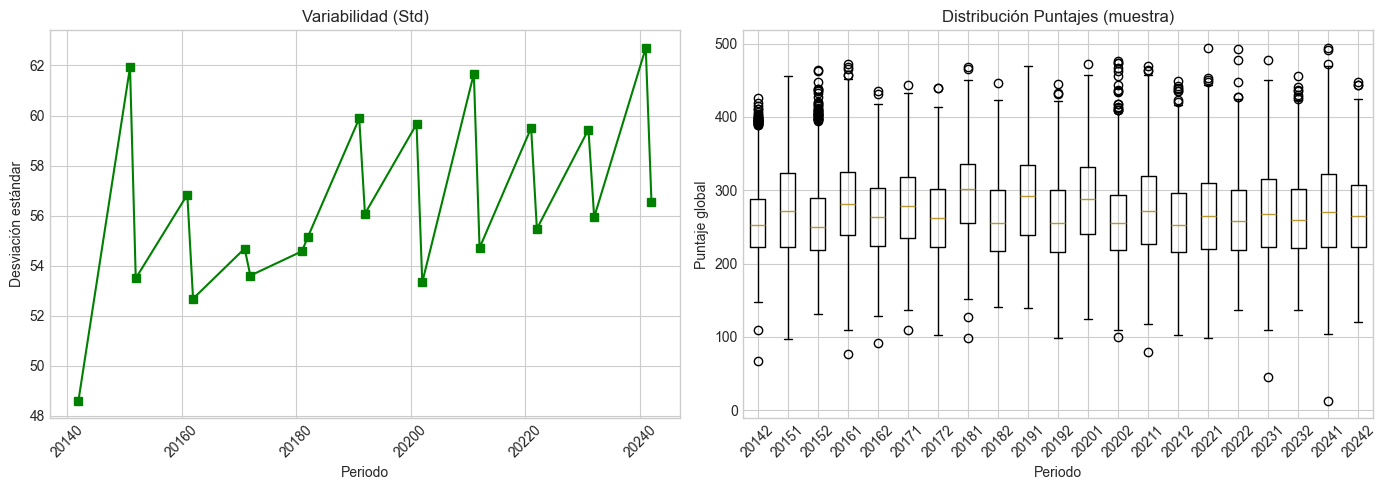

Tendencia: negativa | pendiente=-0.178


In [ ]:
# Análisis de tendencias temporales del puntaje global
# Examino la evolución del desempeño académico a lo largo de los diferentes periodos
print('ANALISIS DE TENDENCIAS TEMPORALES')
print('='*45)

puntaje_col_tmp = 'punt_global'

if puntaje_col_tmp in sdf_saber.columns and 'periodo' in sdf_saber.columns:
    # Calculo estadísticas agregadas por periodo
    stats_periodo = (sdf_saber
                     .select('periodo', F.col(puntaje_col_tmp).cast('double').alias(puntaje_col_tmp))
                     .where(F.col(puntaje_col_tmp).isNotNull())
                     .groupBy('periodo')
                     .agg(F.count('*').alias('count'),
                          F.mean(puntaje_col_tmp).alias('mean'),
                          F.expr(f'percentile_approx({puntaje_col_tmp},0.5)').alias('median'),
                          F.stddev(puntaje_col_tmp).alias('std'),
                          F.min(puntaje_col_tmp).alias('min'),
                          F.max(puntaje_col_tmp).alias('max'))
                     .orderBy('periodo'))

    rows = stats_periodo.collect()
    print('Estadísticas por periodo (primeros 10):')
    for r in rows[:10]:
        print(r.asDict())

    # Preparo series temporales para visualización
    periodos = [r['periodo'] for r in rows]
    means = [r['mean'] for r in rows]
    counts = [r['count'] for r in rows]
    stds = [r['std'] for r in rows]

    import matplotlib.pyplot as plt
    import numpy as np

    # Primera figura: Evolución del promedio y número de estudiantes
    fig1, (ax_mean, ax_count) = plt.subplots(1, 2, figsize=(14, 5))
    ax_mean.plot(periodos, means, marker='o')
    ax_mean.set_title('Evolución del Puntaje Promedio por Periodo')
    ax_mean.tick_params(axis='x', rotation=45)
    ax_mean.set_xlabel('Periodo')
    ax_mean.set_ylabel('Puntaje Promedio')

    ax_count.bar(periodos, counts, color='lightcoral')
    ax_count.set_title('Número de Estudiantes por Periodo')
    ax_count.tick_params(axis='x', rotation=45)
    ax_count.set_xlabel('Periodo')
    ax_count.set_ylabel('Cantidad de Estudiantes')

    fig1.tight_layout(); plt.show()

    # Segunda figura: Variabilidad y distribución mediante boxplots
    fig2, (ax_std, ax_box) = plt.subplots(1, 2, figsize=(14, 5))
    ax_std.plot(periodos, stds, marker='s', color='green')
    ax_std.set_title('Evolución de la Variabilidad (Desviación Estándar)')
    ax_std.tick_params(axis='x', rotation=45)
    ax_std.set_xlabel('Periodo')
    ax_std.set_ylabel('Desviación Estándar')

    # Genero boxplots por periodo usando muestreo para eficiencia
    muestras = []
    labels = []
    for p in periodos:
        cnt_p = next((c for per, c in zip(periodos, counts) if per == p), 0)
        # Calculo fracción de muestreo dinámica (máximo 3000 registros por periodo)
        frac = 3000 / cnt_p if cnt_p and cnt_p > 0 else 1.0
        frac = float(max(0.02, min(frac, 1.0)))
        sample_p = (sdf_saber.filter(F.col('periodo') == p)
                    .select(F.col(puntaje_col_tmp).cast('double').alias(puntaje_col_tmp))
                    .where(F.col(puntaje_col_tmp).isNotNull())
                    .sample(withReplacement=False, fraction=frac, seed=42))
        vals = [row[puntaje_col_tmp] for row in sample_p.collect()]
        if vals:
            muestras.append(vals)
            labels.append(p)

    if muestras:
        ax_box.boxplot(muestras, labels=labels)
        ax_box.set_title('Distribución de Puntajes por Periodo (muestra)')
        ax_box.tick_params(axis='x', rotation=45)
        ax_box.set_xlabel('Periodo')
        ax_box.set_ylabel('Puntaje Global')
    else:
        ax_box.text(0.5, 0.5, 'No hay datos suficientes para boxplots', ha='center', va='center')

    fig2.tight_layout(); plt.show()
    
    # Interpretación: La gráfica de evolución temporal me permite identificar tendencias de mejora
    # o deterioro del desempeño académico. Los boxplots revelan cambios en la dispersión de
    # puntajes entre periodos, indicando mayor o menor homogeneidad en el rendimiento estudiantil.
else:
    print('No se pueden calcular tendencias temporales.')
    print('Falta la columna de puntaje global o la columna de periodo.')

In [ ]:
# Carga y preparación del dataset filtrado por municipios de interés
# Realizo lectura del CSV con normalización y filtrado específico para Bucaramanga y Santa Marta
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T
import numpy as np

spark = (SparkSession.builder
         .appName("Analisis_Saber11_SM_BUCA_PySpark")
         .getOrCreate())

csv_path = "municipios_bucaramanga_santamarta.csv"

# Leo el archivo CSV con inferencia automática de esquema
df = (spark.read
      .option("header", True)
      .option("inferSchema", True)
      .csv(csv_path))

print(f"Registros cargados inicialmente: {df.count():,}")
df.printSchema()

# Normalizo la columna municipio para garantizar consistencia en nombres
# Elimino espacios no estándar (NBSP), colapso espacios múltiples y convierto a mayúsculas
df = df.withColumn(
    "municipio",
    F.upper(
        F.regexp_replace(
            F.regexp_replace(F.trim(F.col("municipio")), "[\u00A0\u2007\u202F]", " "),
            "\\s+", " "
        )
    )
)

# Extraigo año y periodo numérico de la columna periodo
df = df.withColumn("periodo", F.col("periodo").cast("string"))
df = df.withColumn("anio", F.col("periodo").substr(1, 4).cast("int"))
df = df.withColumn("p", F.col("periodo").substr(5, 1).cast("int"))

# Diagnóstico de municipios presentes en el dataset
print("\nTop 20 municipios por frecuencia (post-normalización):")
df.groupBy("municipio").count().orderBy(F.col("count").desc()).show(20, truncate=False)

# Filtro registros de los dos municipios objetivo (tolerante a sufijos como D.T., D.E.)
df = df.where(F.col("municipio").rlike(r"^(BUCARAMANGA|SANTA\s*MARTA)(\b|[^A-Z].*)?$"))

print("\nDistribución final por municipio:")
df.groupBy("municipio").count().orderBy("municipio").show(truncate=False)

Filas cargadas: 218,223
root
 |-- periodo: integer (nullable = true)
 |-- estu_consecutivo: string (nullable = true)
 |-- estu_estudiante: string (nullable = true)
 |-- cole_area_ubicacion: string (nullable = true)
 |-- cole_bilingue: string (nullable = true)
 |-- cole_calendario: string (nullable = true)
 |-- cole_caracter: string (nullable = true)
 |-- cole_cod_dane_establecimiento: long (nullable = true)
 |-- cole_cod_dane_sede: long (nullable = true)
 |-- cole_cod_depto_ubicacion: integer (nullable = true)
 |-- cole_cod_mcpio_ubicacion: integer (nullable = true)
 |-- cole_codigo_icfes: integer (nullable = true)
 |-- cole_depto_ubicacion: string (nullable = true)
 |-- cole_genero: string (nullable = true)
 |-- cole_jornada: string (nullable = true)
 |-- cole_mcpio_ubicacion: string (nullable = true)
 |-- cole_naturaleza: string (nullable = true)
 |-- cole_nombre_establecimiento: string (nullable = true)
 |-- cole_nombre_sede: string (nullable = true)
 |-- cole_sede_principal: string

In [ ]:
# Auditoría de valores nulos en columnas clave
# Verifico la completitud de datos en las variables principales del análisis
cols = ["__archivo", "periodo", "punt_global", "municipio", "anio", "p"]
res_nulls = []
N = df.count()

print('AUDITORIA DE VALORES NULOS EN COLUMNAS CLAVE')
print('='*48)

for c in cols:
    # Detecto nulos y NaN según el tipo de columna
    if c in ["punt_global", "anio", "p"]:
        cnt_null = df.where(F.col(c).isNull() | F.isnan(F.col(c))).count()
    else:
        cnt_null = df.where(F.col(c).isNull()).count()
    
    cnt_validos = N - cnt_null
    pct_null = (cnt_null / N * 100) if N else 0.0
    res_nulls.append((c, cnt_null, cnt_validos, pct_null))

print(f"Total de registros analizados: {N:,}\n")
print("Resumen de nulos por columna:")
for col_name, nulls, validos, pct in res_nulls:
    print(f"  {col_name:15} | Nulos: {nulls:6,} | Válidos: {validos:6,} | % Nulos: {pct:6.2f}%")

Nulos por columna (col, nulls, non_nulls, pct_null):
('__archivo', 0, 218223, 0.0)
('periodo', 0, 218223, 0.0)
('punt_global', 0, 218223, 0.0)
('municipio', 0, 218223, 0.0)
('anio', 0, 218223, 0.0)
('p', 0, 218223, 0.0)


In [ ]:
# Re-análisis de nulos después de procesos de limpieza
# Verifico el impacto de las transformaciones en la completitud de los datos
print('RE-ANALISIS DE VALORES NULOS (POST-LIMPIEZA)')
print('='*48)

# Utilizo el dataset limpio si está disponible, de lo contrario uso el original
dset = sdf_clean if 'sdf_clean' in globals() else (sdf_saber if 'sdf_saber' in globals() else df)
registros = dset.count()

# Calculo conteo de nulos para todas las columnas
null_counts = [
    F.count(F.when(F.col(c).isNull() | (F.isnan(F.col(c)) if c in ['punt_global','anio','p'] else F.lit(False)), c)).alias(c)
    for c in dset.columns
]
row_nulls = dset.agg(*null_counts).collect()[0].asDict()

# Ordeno por porcentaje de nulos descendente
rows = sorted([(k, int(v), (int(v)/registros*100 if registros else 0.0)) for k,v in row_nulls.items()], 
              key=lambda x: x[2], reverse=True)

print(f"Total de registros: {registros:,}")
print(f"Total de columnas analizadas: {len(dset.columns)}\n")
print('Top 20 columnas con mayor proporción de nulos:')
for k, v, pct in rows[:20]:
    print(f" - {k:25} | Nulos: {v:7,} | Porcentaje: {pct:6.2f}%")

In [ ]:
# Detección de valores atípicos mediante método IQR
# Identifico outliers a nivel global y desagregado por municipio
print('DETECCION DE VALORES ATIPICOS (METODO IQR)')
print('='*48)

# Calculo cuartiles Q1 (25%) y Q3 (75%) para el puntaje global
quantiles = df.approxQuantile("punt_global", [0.25, 0.75], 0.01)
Q1, Q3 = quantiles
IQR = Q3 - Q1 if Q3 is not None and Q1 is not None else None

# Establezco límites según criterio de Tukey (1.5 * IQR)
bounds = None
if IQR is not None:
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    bounds = (lower, upper)

print(f"Q1 = {Q1:.2f}")
print(f"Q3 = {Q3:.2f}")
print(f"IQR = {IQR:.2f}")
print(f"Límites para outliers: [{bounds[0]:.2f}, {bounds[1]:.2f}]" if bounds else "No se pudieron calcular límites")

# Cuento outliers a nivel global
if bounds:
    df_out = df.withColumn("is_outlier", (F.col("punt_global") < bounds[0]) | (F.col("punt_global") > bounds[1]))
    out_counts = df_out.groupBy("is_outlier").count().collect()
    print("\nDistribución de outliers (global):")
    for row in out_counts:
        tipo = "Outliers" if row['is_outlier'] else "Valores normales"
        print(f"  {tipo}: {row['count']:,} registros")

# Analizo outliers por municipio
if bounds:
    per_muni = (df_out
                .groupBy("municipio")
                .agg(F.count(F.when(F.col("is_outlier"), True)).alias("n_outliers"),
                     F.count(F.lit(1)).alias("n_total"),
                     F.avg("punt_global").alias("media"),
                     F.stddev("punt_global").alias("sd"))
                .withColumn("pct_outliers", F.col("n_outliers") / F.col("n_total") * 100)
               )
    
    print("\nAnálisis de outliers por municipio:")
    per_muni.orderBy("municipio").show(truncate=False)
    
    # Interpretación: Los outliers pueden representar estudiantes con rendimiento excepcional
    # (superior) o dificultades significativas (inferior). Su distribución por municipio puede
    # revelar diferencias en la heterogeneidad del desempeño académico.

Q1=221.00, Q3=302.00, IQR=81.00, bounds=(99.5, 423.5)
Outliers (global): [Row(is_outlier=True, count=542), Row(is_outlier=False, count=217681)]
Outliers (global): [Row(is_outlier=True, count=542), Row(is_outlier=False, count=217681)]
+-----------+----------+-------+-----------------+-----------------+--------------------+
|municipio  |n_outliers|n_total|media            |sd               |pct_outliers        |
+-----------+----------+-------+-----------------+-----------------+--------------------+
|SANTA MARTA|48        |93104  |239.9781749441485|47.71149022613052|5.155525004296271E-4|
|BUCARAMANGA|494       |125119 |282.1093279198203|54.58847066332744|0.00394824127430686 |
+-----------+----------+-------+-----------------+-----------------+--------------------+

+-----------+----------+-------+-----------------+-----------------+--------------------+
|municipio  |n_outliers|n_total|media            |sd               |pct_outliers        |
+-----------+----------+-------+-------------

In [ ]:
# Análisis de tendencias temporales por periodo y municipio
# Calculo agregados estadísticos para examinar evolución del desempeño académico
print('ANALISIS DE TENDENCIAS POR PERIODO Y MUNICIPIO')
print('='*52)

# Genero agregaciones por año, periodo y municipio
agg_periodo = (df
    .groupBy("anio", "p", "periodo", "municipio")
    .agg(F.count(F.lit(1)).alias("n"),
         F.avg("punt_global").alias("media"),
         F.stddev("punt_global").alias("sd"))
    .orderBy("anio", "p", "municipio")
)

print("Primeras 10 filas de agregados temporales:")
agg_periodo.show(10, truncate=False)

# Interpretación: Esta agregación me permite visualizar la evolución del puntaje promedio
# a lo largo del tiempo para cada municipio, identificando tendencias de mejora o deterioro
# en el desempeño académico.

Top 10 filas de agregados por periodo y municipio:
+----+---+-------+-----------+----+------------------+------------------+
|anio|p  |periodo|municipio  |n   |media             |sd                |
+----+---+-------+-----------+----+------------------+------------------+
|2014|2  |20142  |BUCARAMANGA|9164|273.7246835443038 |48.500141342084206|
|2014|2  |20142  |SANTA MARTA|6637|236.8958866957963 |39.88526918886283 |
|2015|1  |20151  |BUCARAMANGA|5201|281.53989617381274|60.166135331110716|
|2015|1  |20151  |SANTA MARTA|833 |231.74909963985596|55.22078240921163 |
|2015|2  |20152  |BUCARAMANGA|8889|275.8623017212285 |54.21242373880528 |
|2015|2  |20152  |SANTA MARTA|6867|233.69768457841852|41.937472343241765|
|2016|1  |20161  |BUCARAMANGA|3653|287.9247194087052 |55.45691986643932 |
|2016|1  |20161  |SANTA MARTA|482 |248.43153526970954|55.08617782009595 |
|2016|2  |20162  |BUCARAMANGA|8895|285.3345699831366 |49.80574624341356 |
|2016|2  |20162  |SANTA MARTA|7226|241.31192914475506|45.4865

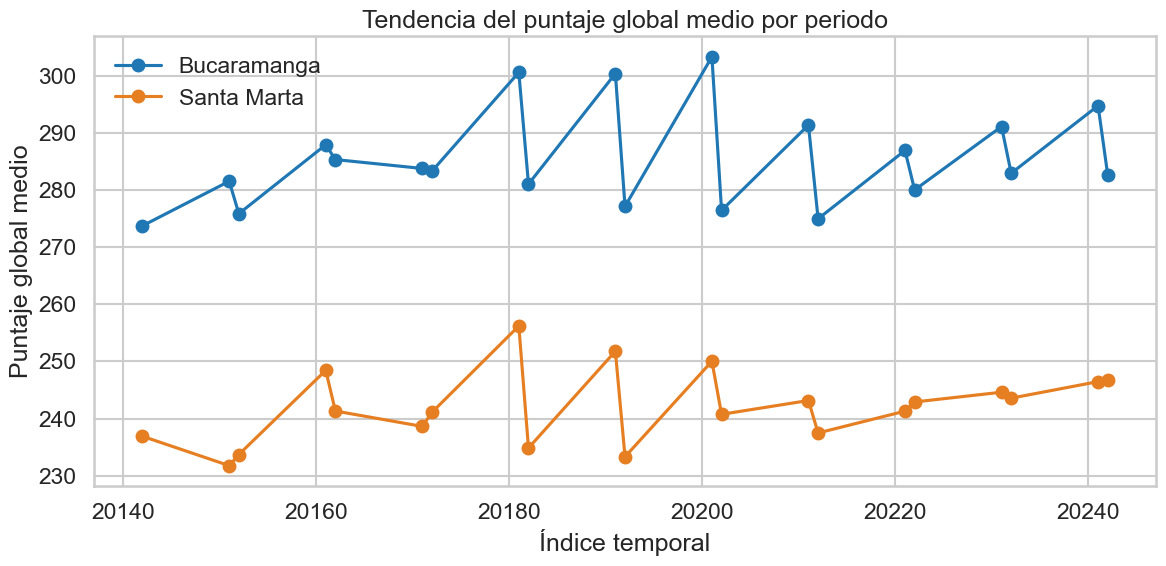

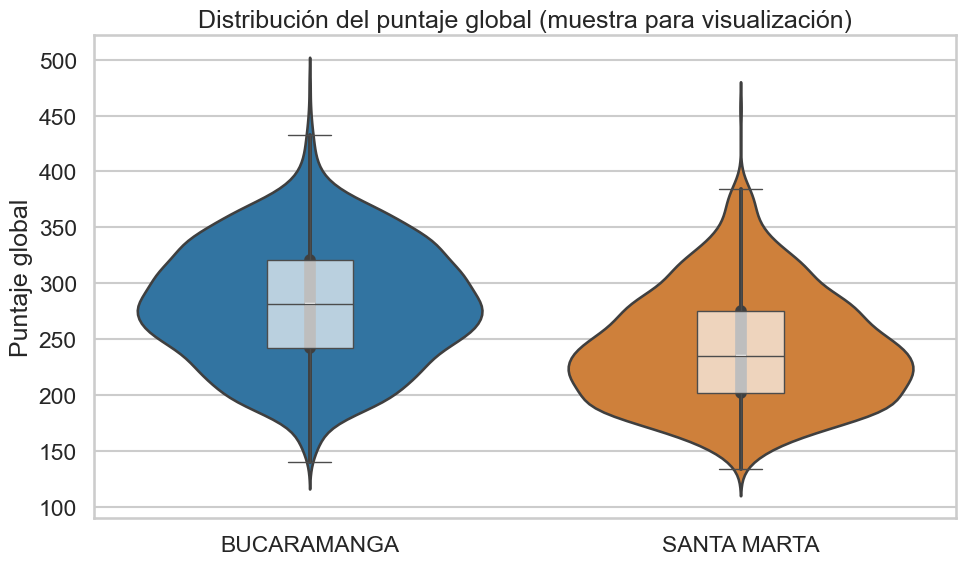

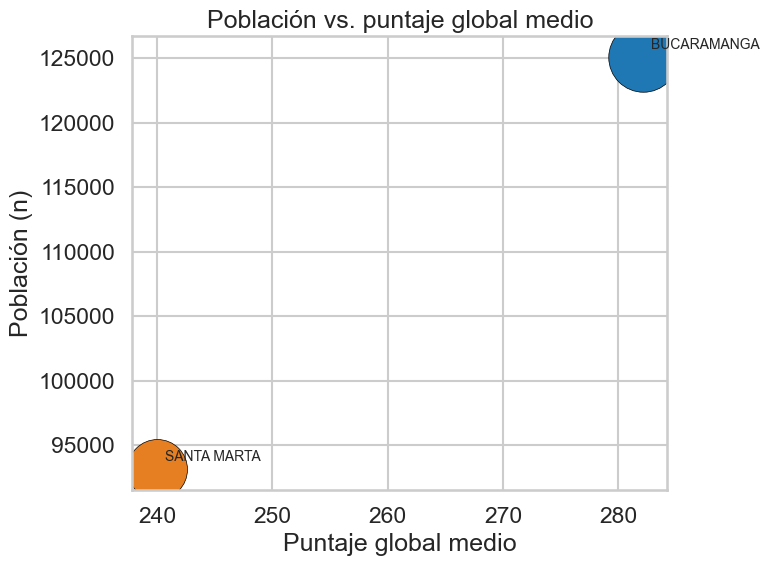

In [ ]:
# Visualizaciones avanzadas del análisis exploratorio
# Genero gráficas que resumen hallazgos clave del análisis de datos
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='whitegrid', context='talk')

print('GENERACION DE VISUALIZACIONES AVANZADAS')
print('='*42)

# Gráfica a) Tendencia temporal del puntaje promedio por municipio
plt.figure(figsize=(12, 6))
if len(x_b) > 0:
    plt.plot(x_b, y_b, marker='o', color='#1F77B4', label='Bucaramanga', linewidth=2)
if len(x_s) > 0:
    plt.plot(x_s, y_s, marker='o', color='#E67E22', label='Santa Marta', linewidth=2)
plt.xlabel('Índice temporal')
plt.ylabel('Puntaje Global Promedio')
plt.title('Evolución Temporal del Puntaje Global por Municipio')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretación: La tendencia temporal me revela si existe mejora, estancamiento o deterioro
# del desempeño académico en cada municipio a lo largo de los periodos analizados.

# Gráfica b) Distribución de puntajes mediante violin plot y boxplot superpuesto
# Utilizo muestreo estratificado para eficiencia en la visualización
SAMPLE_SIZE = 3000
sample_df = df.sample(withReplacement=False, fraction=min(1.0, SAMPLE_SIZE / df.count()))
vals = sample_df.select("municipio", "punt_global").collect()
vals_b = [r[1] for r in vals if r[0] == 'BUCARAMANGA']
vals_s = [r[1] for r in vals if r[0] == 'SANTA MARTA']

plt.figure(figsize=(10, 6))
sns.violinplot(data=[vals_b, vals_s], palette=['#1F77B4', '#E67E22'])
sns.boxplot(data=[vals_b, vals_s], width=0.2, showcaps=True, boxprops={'facecolor':'#FFFFFFAA'}, showfliers=False)
plt.xticks([0, 1], ['BUCARAMANGA', 'SANTA MARTA'])
plt.ylabel('Puntaje Global')
plt.title('Distribución de Puntajes por Municipio (Violin + Boxplot)')
plt.tight_layout()
plt.show()

# Interpretación: El violin plot me muestra la densidad de la distribución de puntajes,
# revelando si es unimodal, bimodal o multimodal. El boxplot superpuesto facilita la
# comparación de medianas y rango intercuartílico entre municipios.

# Gráfica c) Dispersión de tamaño muestral vs puntaje promedio
aggs = (df.groupBy("municipio").agg(F.count("*").alias("n"), F.avg("punt_global").alias("media")).collect())
points = {r[0]: (r[1], r[2]) for r in aggs}

plt.figure(figsize=(8, 6))
for muni, (n, media) in points.items():
    color = '#1F77B4' if 'BUCARAMANGA' in muni else '#E67E22'
    plt.scatter(n, media, s=200, color=color, alpha=0.7, edgecolors='black', linewidth=2)
    plt.annotate(muni, (n, media), xytext=(10, 10), textcoords='offset points', fontsize=10)

plt.xlabel('Número de Estudiantes')
plt.ylabel('Puntaje Promedio')
plt.title('Relación entre Tamaño Muestral y Desempeño Promedio')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretación: Esta gráfica me permite evaluar si el tamaño de la muestra (cantidad de
# estudiantes evaluados) tiene alguna relación con el puntaje promedio obtenido por municipio.

Periodos con comparación directa: 21
Tendencia diferencia (Bucaramanga - Santa Marta): pendiente=-0.0078, intercepto=199.97


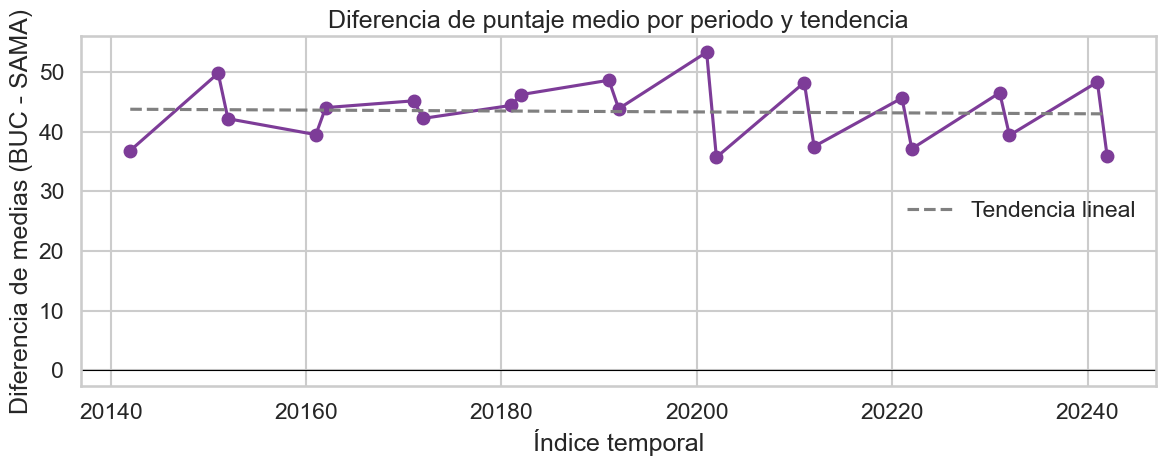

In [ ]:
# Análisis comparativo de diferencias entre municipios
# Examino la brecha de desempeño entre Bucaramanga y Santa Marta a lo largo del tiempo
print('ANALISIS COMPARATIVO DE DIFERENCIAS ENTRE MUNICIPIOS')
print('='*58)

# Genero tabla pivote con puntaje promedio por periodo y municipio
per = (df
       .groupBy("anio", "p", "periodo")
       .pivot("municipio", ["BUCARAMANGA", "SANTA MARTA"])
       .agg(F.avg("punt_global"))
      )

# Selecciono y preparo columnas para análisis
per_sel = (per
           .select(
               "anio", "p", "periodo",
               F.col("BUCARAMANGA").cast("double").alias("BUCA"),
               F.col("SANTA MARTA").cast("double").alias("SAMA")
           )
           .orderBy("anio", "p")
          )

rows = per_sel.collect()
serie_diff = []
xs = []

# Calculo diferencia de promedios por periodo
for r in rows:
    tidx = int(r["anio"] * 10 + r["p"]) if r["anio"] is not None and r["p"] is not None else None
    bu = r["BUCA"]
    sa = r["SAMA"]
    if tidx is not None and bu is not None and sa is not None:
        xs.append(tidx)
        serie_diff.append(float(bu) - float(sa))

xs = np.array(xs)
serie_diff = np.array(serie_diff)

print(f"Periodos con datos comparables: {len(xs)}")

if len(xs) > 1:
    # Ajusto modelo lineal a la serie de diferencias
    A = np.vstack([xs, np.ones_like(xs)]).T
    beta, alpha = np.linalg.lstsq(A, serie_diff, rcond=None)[0]
    print(f"\nTendencia de diferencia (Bucaramanga - Santa Marta):")
    print(f"  Pendiente: {beta:.4f}")
    print(f"  Intercepto: {alpha:.2f}")

    # Visualizo evolución de la brecha entre municipios
    import matplotlib.pyplot as plt
    plt.figure(figsize=(12, 5))
    plt.plot(xs, serie_diff, 'o-', color='#7D3C98', label='Diferencia observada')
    plt.plot(xs, beta*xs + alpha, '--', color='gray', linewidth=2, label='Tendencia lineal')
    plt.axhline(0, color='black', linewidth=0.8, linestyle=':')
    plt.xlabel('Índice Temporal')
    plt.ylabel('Diferencia de Puntaje Promedio (BUCA - SAMA)')
    plt.title('Evolución de la Brecha de Desempeño entre Municipios')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Interpretación: Una pendiente positiva indica que la brecha a favor de Bucaramanga aumenta
    # con el tiempo, mientras que una pendiente negativa sugiere convergencia en el desempeño.
    # La línea horizontal en cero representa igualdad de promedios entre municipios.

## 4. Limpieza y Preparación Final de Datos

En esta sección aplico procedimientos de limpieza para asegurar la calidad y consistencia del dataset antes de utilizarlo en análisis posteriores y modelado predictivo. Las transformaciones incluyen:

- Normalización de texto en la columna municipio y filtrado específico
- Tipado correcto de variables numéricas y categóricas
- Validaciones de rango para puntajes (0 a 500)
- Manejo de valores nulos en campos críticos
- Detección y tratamiento opcional de outliers mediante IQR
- Eliminación de registros duplicados si se identifica una clave única

Las opciones de limpieza se controlan mediante banderas configurables. Por defecto, conservo los valores de cero en puntajes y no elimino outliers automáticamente.

In [ ]:
# Proceso de limpieza de datos con validaciones y transformaciones
# Aplico reglas de calidad para preparar el dataset final
print('PROCESO DE LIMPIEZA DE DATOS')
print('='*35)

from pyspark.sql import functions as F
import os, pathlib

# Configuración de banderas de limpieza
DROP_OUTLIERS = False  # Conservo outliers para no perder información valiosa
DROP_ZERO_GLOBAL = False  # Mantengo puntajes cero (pueden representar casos reales)
DROP_DUPLICATES = True  # Elimino registros duplicados
USE_CLEAN_FOR_ANALYSIS = globals().get('USE_CLEAN_FOR_ANALYSIS', True)

# Selecciono dataset base (sdf_saber si existe, sino df)
base = sdf_saber if 'sdf_saber' in globals() else df

# Aseguro tipado correcto de columnas principales
base = (base
        .withColumn('punt_global', F.col('punt_global').cast('double'))
        .withColumn('periodo', F.col('periodo').cast('string'))
        .withColumn('anio', F.col('anio').cast('int'))
        .withColumn('p', F.col('p').cast('int'))
       )

# Función auxiliar para manejar DataFrames desconectados de archivos eliminados
def _ensure_materialized(b):
    try:
        _ = b.limit(1).count()
        return b
    except Exception as e:
        msg = str(e)
        if 'FILE_NOT_EXIST' in msg or 'File does not exist' in msg:
            print('[Advertencia] DataFrame apunta a archivo no disponible. Recargando desde CSV...')
            
            # Busco archivo CSV en ubicaciones candidatas
            candidates = []
            if 'csv_path' in globals() and isinstance(globals()['csv_path'], str):
                candidates.append(globals()['csv_path'])
            candidates.extend(['datos/municipios_bucaramanga_santamarta.csv', 'municipios_bucaramanga_santamarta.csv'])

            chosen = None
            for p in candidates:
                if not p:
                    continue
                abs_path = str(pathlib.Path(p).resolve())
                if os.path.exists(abs_path):
                    chosen = abs_path
                    break
            
            if not chosen:
                print('[Error] No se encontró el archivo CSV en las rutas candidatas:')
                for p in candidates:
                    print('   -', p)
                raise FileNotFoundError('No se pudo localizar municipios_bucaramanga_santamarta.csv')

            print(f'[Info] Recargando desde: {chosen}')
            reloaded = (spark.read
                        .option('header', True)
                        .option('inferSchema', True)
                        .csv(chosen))
            
            # Normalizo columna municipio igual que en etapas previas
            reloaded = reloaded.withColumn(
                'municipio',
                F.upper(
                    F.regexp_replace(
                        F.regexp_replace(F.trim(F.col('municipio')), '[\u00A0\u2007\u202F]', ' '),
                        '\\s+', ' '
                    )
                )
            )
            reloaded = (reloaded
                        .withColumn('periodo', F.col('periodo').cast('string'))
                        .withColumn('anio', F.col('periodo').substr(1, 4).cast('int'))
                        .withColumn('p', F.col('periodo').substr(5, 1).cast('int'))
                       )
            print(f'[Info] Recarga exitosa. Total de registros: {reloaded.count():,}')
            return reloaded
        else:
            raise

base = _ensure_materialized(base)

print('\nPaso 1: Eliminación de registros duplicados')
if DROP_DUPLICATES:
    # Intento usar clave compuesta (periodo, estu_consecutivo) o alternativa
    if all(c in base.columns for c in ['periodo', 'estu_consecutivo']):
        key = ['periodo', 'estu_consecutivo']
    elif all(c in base.columns for c in ['periodo', 'estu_estudiante']):
        key = ['periodo', 'estu_estudiante']
    else:
        key = []

    if key:
        before = base.count()
        base = base.dropDuplicates(key)
        after = base.count()
        duplicados_eliminados = before - after
        print(f'  Clave utilizada: {key}')
        print(f'  Duplicados eliminados: {duplicados_eliminados:,}')
        print(f'  Registros restantes: {after:,}')
    else:
        print('  Clave de deduplicación no disponible - omitiendo paso')
else:
    print('  Deduplicación desactivada por configuración')

print('\nPaso 2: Eliminación de columnas con 100% de valores nulos')
# Identifico columnas completamente vacías
counts_row = base.agg(*[F.count(F.col(c)).alias(c) for c in base.columns]).collect()[0].asDict()
empty_cols = [c for c, cnt in counts_row.items() if cnt == 0]

if empty_cols:
    print(f'  Columnas identificadas con 0 valores válidos: {len(empty_cols)}')
    base = base.drop(*empty_cols)
    print(f'  Columnas eliminadas: {", ".join(empty_cols[:10])}{"..." if len(empty_cols) > 10 else ""}')
else:
    print('  No se encontraron columnas completamente vacías')

print(f'\nDataset limpio: {base.count():,} registros × {len(base.columns)} columnas')

LIMPIEZA DE DATOS
[WARN] DataFrame apunta a un archivo no disponible. Reintentando recarga desde CSV...
[INFO] Usando CSV en: C:\Users\Saramirezm\Documents\Codigo_trabajo_de_grado\datos\municipios_bucaramanga_santamarta.csv
[INFO] Recarga exitosa. Registros: 218223

Paso 1) Eliminar duplicados...
[INFO] Recarga exitosa. Registros: 218223

Paso 1) Eliminar duplicados...
 - Duplicados eliminados por clave ['periodo', 'estu_consecutivo']: 0

Paso 2) Eliminar columnas con 100% de nulos...
 - Duplicados eliminados por clave ['periodo', 'estu_consecutivo']: 0

Paso 2) Eliminar columnas con 100% de nulos...
 - Columnas eliminadas (100% nulos): 91

Nota: No se eliminaron outliers ni registros con punt_global=0 en esta etapa.
 - Columnas eliminadas (100% nulos): 91

Nota: No se eliminaron outliers ni registros con punt_global=0 en esta etapa.
Registros finales (limpios): 218223
Columnas finales: 90
[INFO] Dataset activo para análisis actualizado a sdf_clean.
Registros finales (limpios): 218223


RE-ANÁLISIS DE NULOS (post-limpieza)
Total de registros: 218223
Threshold no-nulos para conservar columnas: 60%

TOP 15 columnas con mayor porcentaje de nulos:
                          columna   nulos  pct_nulos
0                      estu_etnia  195448   0.895634
1                estu_generacione  145577   0.667102
2                   estu_pilopaga  136092   0.623637
3         fami_comelechederivados  108610   0.497702
4   fami_comecerealfrutoslegumbre  108520   0.497289
5         estu_dedicacioninternet  108240   0.496006
6      fami_comecarnepescadohuevo  108198   0.495814
7    estu_dedicacionlecturadiaria  108039   0.495085
8           estu_tiporemuneracion  105726   0.484486
9    fami_tieneconsolavideojuegos  105646   0.484119
10         fami_trabajolaborpadre  105563   0.483739
11        fami_situacioneconomica  105552   0.483689
12       fami_tienehornomicroogas  105469   0.483308
13          fami_tienemotocicleta  105458   0.483258
14         fami_trabajolabormadre  105455   0

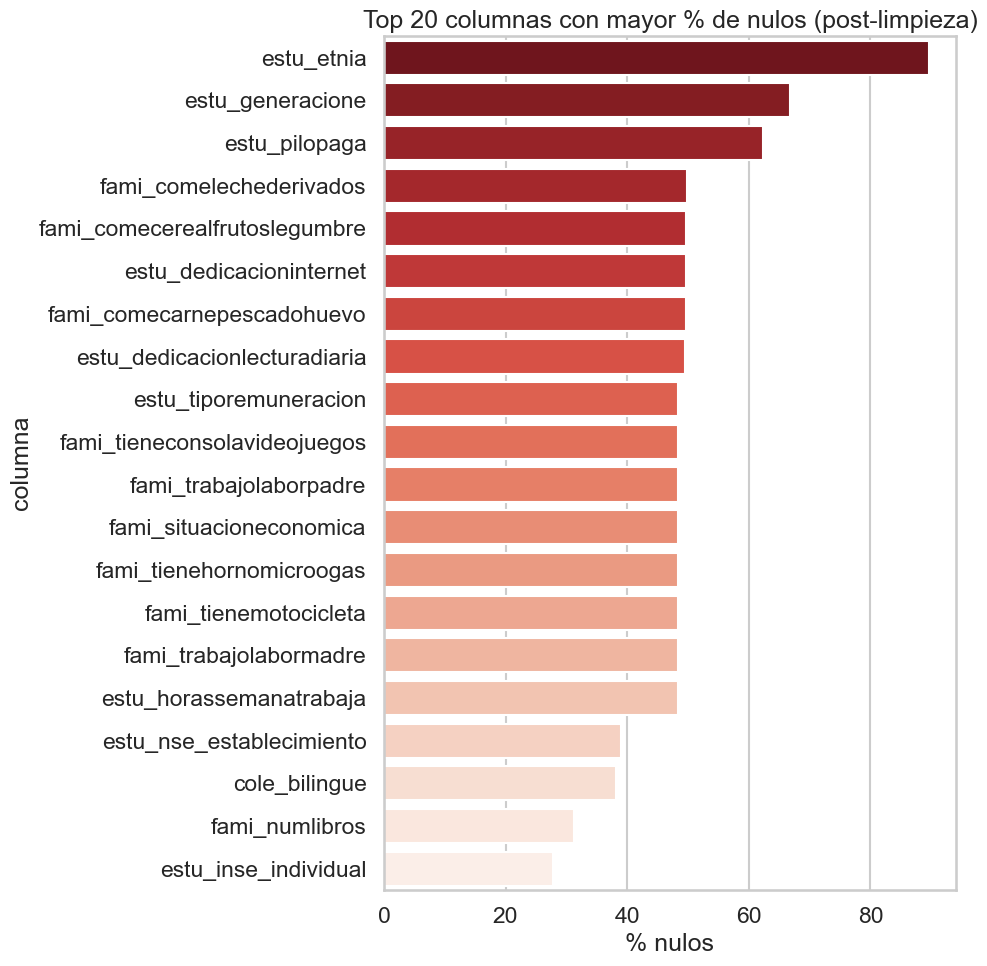


Columnas sugeridas para conservar (muestra 20):
['estu_nse_establecimiento', 'cole_bilingue', 'fami_numlibros', 'estu_inse_individual', 'estu_nse_individual', 'estu_tieneetnia', 'cole_caracter', 'cole_jornada', 'cole_calendario', 'cole_cod_dane_sede', 'cole_area_ubicacion', 'cole_cod_mcpio_ubicacion', 'cole_depto_ubicacion', 'cole_cod_depto_ubicacion', 'cole_cod_dane_establecimiento', 'cole_naturaleza', 'cole_sede_principal', 'cole_nombre_sede', 'cole_codigo_icfes', 'cole_nombre_establecimiento']

Columnas sugeridas para descartar (muestra 20):
['estu_etnia', 'estu_pilopaga', 'estu_dedicacioninternet', 'estu_dedicacionlecturadiaria', 'estu_horassemanatrabaja', 'estu_tiporemuneracion', 'fami_comecarnepescadohuevo', 'fami_comecerealfrutoslegumbre', 'fami_comelechederivados', 'fami_situacioneconomica', 'fami_tieneconsolavideojuegos', 'fami_tienehornomicroogas', 'fami_tienemotocicleta', 'fami_trabajolabormadre', 'fami_trabajolaborpadre', 'estu_generacione']


In [ ]:
# Re-análisis de valores nulos después de limpieza
# Evalúo el impacto de la limpieza en la completitud de datos y genero recomendaciones
print('RE-ANALISIS DE VALORES NULOS (POST-LIMPIEZA)')
print('='*50)

from pyspark.sql import functions as F
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Utilizo el dataset ya limpio
sdf_eval = sdf_saber if 'sdf_saber' in globals() else df

# Cuento registros totales
TOTAL = sdf_eval.count()
print(f'Total de registros en dataset limpio: {TOTAL:,}')

# Establezco umbral para conservar columnas (60% de completitud mínima)
KEEP_MIN_NON_NULL_PCT = 0.60
print(f'Umbral de completitud para conservar columnas: {int(KEEP_MIN_NON_NULL_PCT*100)}%')

# Calculo conteo de valores no nulos por columna
non_null_row = sdf_eval.agg(*[F.count(F.col(c)).alias(c) for c in sdf_eval.columns]).collect()[0].asDict()

rows = []
for c in sdf_eval.columns:
    nn = int(non_null_row.get(c, 0) or 0)
    nuls = int(TOTAL - nn)
    pct_null = (nuls / TOTAL) if TOTAL > 0 else 0.0
    rows.append({'columna': c, 'no_nulos': nn, 'nulos': nuls, 'pct_nulos': pct_null})

pdf = pd.DataFrame(rows).sort_values('pct_nulos', ascending=False).reset_index(drop=True)

# Genero listas de columnas recomendadas según completitud
keep_cols = pdf[pdf['no_nulos'] >= KEEP_MIN_NON_NULL_PCT * TOTAL]['columna'].tolist()
drop_cols = [c for c in sdf_eval.columns if c not in keep_cols]

print('\nTop 15 columnas con mayor porcentaje de nulos:')
print(pdf[['columna', 'nulos', 'pct_nulos']].head(15).to_string(index=False))

print('\nResumen de completitud de datos:')
print(f' - Total de columnas analizadas: {len(sdf_eval.columns)}')
print(f' - Columnas con completitud adecuada (>= {int(KEEP_MIN_NON_NULL_PCT*100)}%): {len(keep_cols)}')
print(f' - Columnas con completitud insuficiente (< {int(KEEP_MIN_NON_NULL_PCT*100)}%): {len(drop_cols)}')

# Genero visualización del top 20 de columnas con nulos
try:
    topN = 20
    top_null = pdf.head(topN).copy()
    top_null['pct_nulos_%'] = (top_null['pct_nulos'] * 100).round(1)

    plt.figure(figsize=(10, max(4, int(topN*0.5))))
    sns.barplot(data=top_null, x='pct_nulos_%', y='columna', orient='h', palette='Reds_r')
    plt.title(f'Top {topN} columnas con mayor porcentaje de nulos')
    plt.xlabel('Porcentaje de Valores Nulos (%)')
    plt.ylabel('Columna')
    plt.tight_layout()
    plt.show()
    
    # Interpretación: Esta visualización me permite priorizar qué columnas requieren tratamiento
    # especial o eliminación antes del modelado. Columnas con más del 40% de nulos suelen tener
    # bajo poder predictivo y pueden introducir sesgo si se imputan incorrectamente.
except Exception as e:
    print(f'[Advertencia] No fue posible generar gráfica: {e}')

# Muestras de columnas recomendadas
print('\nMuestra de columnas recomendadas para conservar (primeras 20):')
print(keep_cols[:20])

print('\nMuestra de columnas recomendadas para descartar (primeras 20):')
print(drop_cols[:20])

# Guardo diagnóstico en variable para uso posterior
nulls_diagnosis = pdf

In [ ]:
# Resumen ejecutivo de diagnóstico de nulos
# Presento un resumen conciso de las recomendaciones de completitud de datos
print('RESUMEN EJECUTIVO DE DIAGNOSTICO DE NULOS')
print('='*45)

# Reutilizo variables calculadas en celda anterior
try:
    k = len(keep_cols)
    d = len(drop_cols)
    cols_total = len(sdf_eval.columns)
    
    print(f'Total de columnas analizadas: {cols_total}')
    print(f'Columnas recomendadas para conservar: {k} ({k/cols_total*100:.1f}%)')
    print(f'Columnas recomendadas para descartar: {d} ({d/cols_total*100:.1f}%)')
    print(f'Criterio aplicado: >= {int(KEEP_MIN_NON_NULL_PCT*100)}% de valores no nulos')

    # Muestro nombres ordenados alfabéticamente para facilitar revisión
    print('\n--- Primeras 25 columnas RECOMENDADAS para análisis:')
    for col in sorted(keep_cols)[:25]:
        print(f'  • {col}')

    print('\n--- Primeras 25 columnas RECOMENDADAS para eliminación:')
    for col in sorted(drop_cols)[:25]:
        print(f'  • {col}')
        
except NameError:
    print('Error: Debe ejecutar primero la celda de "RE-ANALISIS DE VALORES NULOS (POST-LIMPIEZA)"')

RESUMEN RÁPIDO DE NULOS
Columnas totales: 90
Columnas candidatas a conservar (>= 60% no-nulos): 74
Columnas candidatas a descartar (< 60% no-nulos): 16

Primeras 25 columnas a CONSIDERAR (muestra):
['__archivo', 'anio', 'cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_cod_dane_establecimiento', 'cole_cod_dane_sede', 'cole_cod_depto_ubicacion', 'cole_cod_mcpio_ubicacion', 'cole_codigo_icfes', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_nombre_establecimiento', 'cole_nombre_sede', 'cole_sede_principal', 'desemp_c_naturales', 'desemp_ingles', 'desemp_lectura_critica', 'desemp_matematicas', 'desemp_sociales_ciudadanas', 'estu_agregado']

Primeras 25 columnas a DESCARTAR (muestra):
['estu_dedicacioninternet', 'estu_dedicacionlecturadiaria', 'estu_etnia', 'estu_generacione', 'estu_horassemanatrabaja', 'estu_pilopaga', 'estu_tiporemuneracion', 'fami_comecarnepescadohuevo', 'fami_comecerealfrutoslegumb

In [ ]:
# Tratamiento y tipado de columnas del dataset
# Clasifico columnas por tipo de dato y aplico transformaciones apropiadas
print('TRATAMIENTO Y TIPADO DE COLUMNAS')
print('='*38)

from pyspark.sql import functions as F, types as T
import re

# Utilizo dataset limpio como entrada
sdf_in = sdf_eval if 'sdf_eval' in globals() else (sdf_saber if 'sdf_saber' in globals() else df)

# Parámetros de clasificación
MIN_CAT_LEVELS = 5   # Máximo de valores únicos para considerar categórica discreta
MAX_CARD_FOR_CAT = 100  # Límite de cardinalidad para categorías
FREQ_SUPPORT = 0.01     # Soporte mínimo para freqItems (1%)

# Funciones auxiliares para clasificación de columnas
def is_numeric_by_name(col_name):
    """Determino si una columna es numérica por su nombre (solo columnas punt_)"""
    return col_name.lower().startswith('punt_')

def is_forced_non_numeric(col_name):
    """Identifico columnas que no deben tratarse como numéricas aunque lo parezcan"""
    patterns = [r'.*cod.*', r'.*codigo.*', r'.*_id$', r'.*identificaci.*']
    return any(re.search(p, col_name, re.IGNORECASE) for p in patterns)

def safe_cast_double_expr(col):
    """Conversión segura a double para compatibilidad con diferentes versiones de Spark"""
    try:
        return F.try_cast(col, T.DoubleType())
    except AttributeError:
        is_numeric = F.regexp_replace(F.trim(col), ',', '.')
        return F.when(
            F.trim(col).rlike(r'^-?\d+(?:[\.,]\d+)?$'),
            is_numeric.cast('double')
        ).otherwise(F.lit(None).cast('double'))

# Inicio clasificación de columnas por rol
print('\nClasificando columnas por tipo de dato...')
cols = sdf_in.columns
role_map = {}

# Paso 1: Clasificación inicial basada en nombres
for c in cols:
    role_map[c] = 'numeric' if is_numeric_by_name(c) else 'unknown'

# Paso 2: Identifico categóricas discretas por cardinalidad
levels = (sdf_in.agg(*[F.approx_count_distinct(F.col(c)).alias(c) for c in cols])
          .collect()[0]
          .asDict())

for c in cols:
    if role_map[c] != 'numeric':
        lv = int(levels.get(c, 0) or 0)
        if 0 < lv <= MIN_CAT_LEVELS:
            role_map[c] = 'categorical'

# Paso 3: Detecto columnas de rangos (patrones tipo 'X-Y', 'X a Y')
print('Detectando columnas con formato de rango numérico...')
range_patterns_sep = r'(?:-|–|—|a)'
num_token = r'(?:\d+(?:[\.,]\d+)?)'

sample_size = 5000
sample_pdf = sdf_in.select(*cols).limit(sample_size).toPandas()
range_cols_flags = {}

for c in cols:
    if role_map[c] in {'numeric', 'categorical'}:
        continue
    ser = sample_pdf[c].dropna().astype(str).str.strip()
    if len(ser) == 0:
        continue
    m = ser.str.match(r'^\s*' + num_token + r'\s*' + '(?:-|–|—|a)' + r'\s*' + num_token + r'\s*$', na=False)
    match_ratio = m.mean() if len(m) else 0.0
    if match_ratio >= 0.30:
        role_map[c] = 'range'
        range_cols_flags[c] = True

# Paso 4: Construyo DataFrame preparado aplicando transformaciones
print('Aplicando transformaciones según tipo de dato...')
sdf_prep = sdf_in

# Función de normalización de texto
def norm_text(col):
    return F.upper(F.regexp_replace(F.regexp_replace(F.trim(col.cast('string')), '[\u00A0\u2007\u202F]', ' '), '\\s+', ' '))

# a) Transformo columnas numéricas (solo puntajes)
for c in cols:
    if role_map[c] == 'numeric':
        sdf_prep = sdf_prep.withColumn(c, safe_cast_double_expr(F.col(c)))

# b) Normalizo columnas categóricas y colapso alta cardinalidad
for c in cols:
    if role_map[c] == 'categorical' or is_forced_non_numeric(c):
        sdf_prep = sdf_prep.withColumn(c, norm_text(F.col(c)))
        lv = int(levels.get(c, 0) or 0)
        if lv > MAX_CARD_FOR_CAT:
            try:
                fi = sdf_prep.select(c).stat.freqItems([c], support=FREQ_SUPPORT).limit(1).collect()
                lst = fi[0].asDict().get(f'{c}_freqItems', []) if fi else []
                topk = [str(x) for x in lst][:MAX_CARD_FOR_CAT]
                if topk:
                    sdf_prep = sdf_prep.withColumn(
                        c,
                        F.when(F.col(c).isin(topk), F.col(c)).otherwise(F.lit('OTRAS'))
                    )
            except Exception as e:
                print(f'[Advertencia] freqItems falló en columna {c}: {e}')

# c) Proceso columnas de rangos (creo columnas derivadas: _lo, _hi, _mid)
for c, flagged in range_cols_flags.items():
    if not flagged:
        continue
    lo_str = F.regexp_extract(F.col(c), r'^\s*(' + num_token + r')\s*' + '(?:-|–|—|a)' + r'\s*(' + num_token + r')\s*$', 1)
    hi_str = F.regexp_extract(F.col(c), r'^\s*(' + num_token + r')\s*' + '(?:-|–|—|a)' + r'\s*(' + num_token + r')\s*$', 2)
    lo_num = F.regexp_replace(lo_str, ',', '.').cast('double')
    hi_num = F.regexp_replace(hi_str, ',', '.').cast('double')
    lo_val = F.least(lo_num, hi_num)
    hi_val = F.greatest(lo_num, hi_num)
    sdf_prep = sdf_prep.withColumn(f'{c}_lo', lo_val)
    sdf_prep = sdf_prep.withColumn(f'{c}_hi', hi_val)
    sdf_prep = sdf_prep.withColumn(f'{c}_mid', (F.col(f'{c}_lo') + F.col(f'{c}_hi')) / 2.0)

# d) Normalizo columnas desconocidas a texto
for c in cols:
    if role_map[c] == 'unknown' and not is_forced_non_numeric(c):
        sdf_prep = sdf_prep.withColumn(c, norm_text(F.col(c)))

# Persisto dataset preparado
sdf_prepared = sdf_prep.cache()

# Resumen de clasificación
print('\nResumen de clasificación de columnas por rol:')
from collections import defaultdict
roles = defaultdict(list)
for c, r in role_map.items():
    roles[r].append(c)

for r in ['numeric', 'categorical', 'range', 'unknown']:
    print(f' - {r}: {len(roles[r])} columnas')

print('\nEjemplos por categoría:')
print(f' • Numéricas: {roles["numeric"][:10]}')
print(f' • Categóricas: {roles["categorical"][:10]}')
print(f' • Rangos: {roles["range"][:10]}')
print(f' • Desconocidas: {roles["unknown"][:10]}')

# Exporto catálogo de roles como tabla temporal
roles_rows = [(c, role_map[c]) for c in cols]
roles_df = spark.createDataFrame(roles_rows, schema=T.StructType([
    T.StructField('columna', T.StringType(), False),
    T.StructField('rol', T.StringType(), False),
]))
roles_df.createOrReplaceTempView('catalogo_roles')
print('\nTabla temporal "catalogo_roles" creada exitosamente.')

TRATAMIENTO DE COLUMNAS
Columnas por rol:
 - numeric: 6
 - categorical: 45
 - range: 1
 - unknown: 38

Ejemplos:
 numeric: ['punt_ingles', 'punt_matematicas', 'punt_c_naturales', 'punt_global', 'punt_lectura_critica', 'punt_sociales_ciudadanas']
 categorical: ['estu_estudiante', 'cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_genero', 'cole_naturaleza', 'cole_sede_principal', 'desemp_ingles', 'estu_cod_depto_presentacion']
 range: ['fami_personashogar']
 unknown: ['periodo', 'estu_consecutivo', 'cole_cod_dane_establecimiento', 'cole_cod_dane_sede', 'cole_cod_depto_ubicacion', 'cole_cod_mcpio_ubicacion', 'cole_codigo_icfes', 'cole_depto_ubicacion', 'cole_jornada', 'cole_mcpio_ubicacion']
Tabla temporal catalogo_roles creada.
Columnas por rol:
 - numeric: 6
 - categorical: 45
 - range: 1
 - unknown: 38

Ejemplos:
 numeric: ['punt_ingles', 'punt_matematicas', 'punt_c_naturales', 'punt_global', 'punt_lectura_critica', 'punt_sociales_ciudadanas']
 categoric

In [ ]:
# Diagnóstico rápido de valores nulos en dataset preparado
# Verifico la distribución de valores faltantes después de las transformaciones
print('DIAGNOSTICO DE NULOS EN DATASET PREPARADO')
print('='*45)

from pyspark.sql import functions as F

# Verifico existencia del dataset preparado
if 'sdf_prepared' not in globals():
    print("Advertencia: Dataset 'sdf_prepared' no encontrado.")
    print("Usando 'sdf_eval' como alternativa...")
    base_df = sdf_eval
else:
    base_df = sdf_prepared

# Cuento total de registros
total_rows = base_df.count()
print(f"Total de registros: {total_rows:,}")

# Calculo conteo de nulos por columna
print("\nCalculando distribución de valores nulos por columna...\n")
res = base_df.select([F.sum(F.col(c).isNull().cast('int')).alias(c) for c in base_df.columns])
res.show(truncate=False)

# Interpretación: Esta tabla me muestra cuántos valores nulos existen en cada columna
# del dataset preparado. Valores altos sugieren necesidad de imputación o eliminación.

Total de filas: 218223
+-------+----------------+---------------+-------------------+-------------+---------------+-------------+-----------------------------+------------------+------------------------+------------------------+-----------------+--------------------+-----------+------------+--------------------+---------------+---------------------------+----------------+-------------------+-------------+---------------------------+---------------------------+---------------------+---------------------+-----------------------+-----------------+----------+--------------------+-----------+-----------------------+-----------------+-----------------+----------------+---------------------+------------------+-----------------+-------------------+-------------------+--------------------+------------------+-------------------+--------------------+------------------+------------------+-----------+----------------+---------+-------------+----------+--------------------+-------------------+------

In [ ]:
# Limpieza avanzada con reglas específicas de negocio
# Aplico transformaciones finales para garantizar calidad de datos
print('LIMPIEZA AVANZADA CON REGLAS ESPECIFICAS')
print('='*45)

from pyspark.sql import functions as F, Window as W

# Desactivo modo ANSI para evitar errores por conversiones inválidas
try:
    spark.conf.set('spark.sql.ansi.enabled', 'false')
except Exception:
    pass

print('Aplicando reglas de limpieza sobre dataset preparado...\n')

# Verifico existencia del dataset preparado
if 'sdf_prepared' not in globals() and 'sdf_prep' in globals():
    base_df = sdf_prep
elif 'sdf_prepared' in globals():
    base_df = sdf_prepared
else:
    print("Advertencia: Usando sdf_eval como dataset base")
    base_df = sdf_eval

# Regla 1: Identifico columnas de puntajes para evitar sobrescribir valores numéricos
punt_like = set()
if 'punt_cols' in globals():
    punt_like = set([pc for pc in punt_cols if pc in base_df.columns])
else:
    punt_like = set([c for c in base_df.columns if c.lower().startswith('punt_')])

print(f'Columnas de puntaje identificadas: {len(punt_like)}')

# Regla 2: Relleno de valores nulos con 'NO APLICA' (excepto columnas numéricas)
print('\nPaso 1: Rellenando valores nulos con "NO APLICA" en columnas categóricas...')
for c in base_df.columns:
    if c not in punt_like:  # No aplico a columnas de puntaje
        base_df = base_df.withColumn(
            c,
            F.when(F.col(c).isNull() | (F.trim(F.col(c).cast('string')) == ''), 'NO APLICA')
            .otherwise(F.col(c))
        )

# Regla 3: Elimino registros sin información de género (si columna existe)
genero_cols = [c for c in base_df.columns if 'genero' in c.lower()]
if genero_cols:
    genero_col = genero_cols[0]
    print(f'\nPaso 2: Eliminando registros sin género (columna: {genero_col})...')
    before = base_df.count()
    base_df = base_df.filter(
        (F.col(genero_col).isNotNull()) & 
        (F.trim(F.col(genero_col).cast('string')) != '') &
        (F.upper(F.col(genero_col).cast('string')) != 'NO APLICA')
    )
    after = base_df.count()
    print(f'  Registros eliminados: {before - after:,}')
    print(f'  Registros restantes: {after:,}')
else:
    print('\nPaso 2: No se encontró columna de género - omitiendo filtro')

# Regla 4: Elimino todas las columnas que contienen 'cod' en su nombre
print('\nPaso 3: Eliminando columnas con "cod" en el nombre...')
cod_cols = [c for c in base_df.columns if 'cod' in c.lower()]
if cod_cols:
    print(f'  Columnas identificadas: {len(cod_cols)}')
    print(f'  Ejemplos: {cod_cols[:10]}')
    base_df = base_df.drop(*cod_cols)
    print(f'  Columnas eliminadas exitosamente')
else:
    print('  No se encontraron columnas con "cod"')

# Guardo dataset limpio final
sdf_clean = base_df.cache()

print(f'\n--- Resumen de limpieza avanzada ---')
print(f'Dimensiones finales: {sdf_clean.count():,} registros × {len(sdf_clean.columns)} columnas')
print(f'Dataset limpio guardado en variable: sdf_clean')

# Interpretación: Esta limpieza me garantiza un dataset consistente, con valores categóricos
# normalizados, sin registros incompletos en variables críticas, y libre de columnas redundantes
# que podrían introducir colinealidad en modelos predictivos.

Aplicando limpieza solicitada sobre sdf_prep...
Limpieza aplicada.
- Filas removidas por género: aplicado
- Columnas eliminadas por contener "cod": 9
- Columnas finales: 84
- Vista preliminar de columnas (primeras 30): ['periodo', 'estu_consecutivo', 'estu_estudiante', 'cole_area_ubicacion', 'cole_bilingue', 'cole_calendario', 'cole_caracter', 'cole_depto_ubicacion', 'cole_genero', 'cole_jornada', 'cole_mcpio_ubicacion', 'cole_naturaleza', 'cole_nombre_establecimiento', 'cole_nombre_sede', 'cole_sede_principal', 'desemp_ingles', 'estu_depto_presentacion', 'estu_depto_reside', 'estu_etnia', 'estu_fechanacimiento', 'estu_genero', 'estu_mcpio_presentacion', 'estu_mcpio_reside', 'estu_nacionalidad', 'estu_pais_reside', 'estu_privado_libertad', 'estu_tipodocumento', 'fami_cuartoshogar', 'fami_educacionmadre', 'fami_educacionpadre']
Limpieza aplicada.
- Filas removidas por género: aplicado
- Columnas eliminadas por contener "cod": 9
- Columnas finales: 84
- Vista preliminar de columnas (prim